# MOD 4 Project

#### Name : Filiz Camuz
#### Track: Data Science SP
#### Coach: Eli

-------------------------------------------------

## Time Series Model for Real Estate Investment Company

This model is for suggesting the best 5 zipcodes to invest for a Real Estate Investment Company. Conditions are listed below. 

- Company would like to invest in Texas
- The range of the investment is not defined, it could be any amount
- Company would like to do investment for at least 3 years span. 




# Step 1: Load the Data 

In [420]:
import warnings
warnings.filterwarnings('ignore')
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from IPython.display import set_matplotlib_formats
plt.style.use('ggplot')
warnings.filterwarnings("ignore") #ignore the warnings to avoid a lot of noise from running the procedure

In [421]:
df=pd.read_csv('zillow_data.csv')
df.head(2)

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800


In [422]:
df.shape


(14723, 272)

In [423]:
df.isna().sum()

RegionID         0
RegionName       0
City             0
State            0
Metro         1043
              ... 
2017-12          0
2018-01          0
2018-02          0
2018-03          0
2018-04          0
Length: 272, dtype: int64

In [424]:
df.isna().sum().sum()

157934

In [425]:
df.dtypes

RegionID       int64
RegionName     int64
City          object
State         object
Metro         object
               ...  
2017-12        int64
2018-01        int64
2018-02        int64
2018-03        int64
2018-04        int64
Length: 272, dtype: object


# Step 2: Feature Engineering


### Dealing with Null values

In [426]:
df_full=df # keep the original dataframe as it is (df)
df_full.Metro.fillna(df_full.City, inplace=True) # fill missing metro with city iname
df_full=df_full.bfill(axis='columns') # use .bfill() method to fill missing price data, 
#.bfill() converted datatype to object so, it will be handled later
df_full.index=df_full.RegionName
df_full.drop('RegionName', axis=1, inplace=True)


### Filtering for Chosen Zipcodes 

I will consider **price increase** and the **increase rate (percentage of the increase)** when filtering the data. I will cross refence them by creating a new column as **"criteria"** that stores **increase rate X price increase**  for the last 22 years. 

In [427]:
def select_state_top10 (df, state ):
    df['increase'] =(df['2018-04'] - df['1996-04'])  #calculate price change and the percentage of the increase
    df['increase_rate'] = df['increase']/df['1996-04'] 
    df['criteria']= df['increase']*df['increase_rate']
    df_state=df[df['State']==state] #filter state
    df2 = df_state.iloc[:, 6:]  #select only the price data
    df2.sort_values(by= ['criteria'], ascending=False, inplace=True) #sort by rate and slice top 10
    df10 =  df2.iloc[:10, :].astype(int)  #convert datatype to int
    #df2.sort_values(by= ['criteria'], ascending=False, inplace=True) #sort by increase and slice top 10
    #df10_growth = df2.iloc[:10, :].astype(int) 
    return df10, df

### Convert dataframe to time series 

In [428]:
def convert_to_ts (df):   
    ts=df.drop(['increase','increase_rate','criteria'], axis=1)  #drop columns other than price 
    ts=ts.T     # Transpose the dataframe
    ts.index=pd.to_datetime(ts.index)   #change index type to timestamp
    ts=ts.astype(int)  
    return ts

In [429]:
def melt_data(df):
    """return melted to long-format df with averaged prices by using groupby and mean agg-fx
input df - must be in wide format
    """
    
    melted = pd.melt(df, id_vars=['RegionName', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

#ts_avg = melt_data(df_initial)['value']

# Step 3: EDA and Visualization

In [430]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}

plt.rc('font', **font)
plt.gcf().autofmt_xdate()
# NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!

<Figure size 1080x288 with 0 Axes>

In [431]:
df_full_states=df_full_2.drop(['RegionID', 'City', 'CountyName','Metro','SizeRank'],axis=1)


In [432]:
df_full_states

,State,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,...,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,increase,increase_rate,criteria
RegionName,,,,,,,,,,,,,,,,,,,,,
60657,IL,334200,335400,336500,337600,338500,339500,340400,341300,342600,...,1009600,1013300,1018700,1024400,1030700,1033800,1030600,696400,2.08378,1.45115e+06
75070,TX,235700,236900,236700,235400,233300,230600,227300,223400,219600,...,314100,315000,316600,318100,319600,321100,321800,86100,0.365295,31451.9
77494,TX,210400,212200,212200,210700,208300,205500,202500,199800,198300,...,320400,320800,321200,321200,323000,326900,329900,119500,0.567966,67871.9
60614,IL,498100,500900,503100,504600,505500,505700,505300,504200,503600,...,1291500,1296600,1299000,1302700,1306400,1308500,1307000,808900,1.62397,1.31363e+06
79936,TX,77300,77300,77300,77300,77400,77500,77600,77700,77700,...,120300,120300,120300,120300,120500,121000,121500,44200,0.571798,25273.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1338,MA,94600,94300,94000,93700,93400,93200,93000,92900,92700,...,218500,218100,216400,213100,209800,209200,209300,114700,1.21247,139071
3293,NH,92700,92500,92400,92200,92100,91900,91700,91300,90900,...,215200,214300,213100,213700,218300,222700,225800,133100,1.43581,191107
40404,KY,57100,57300,57500,57700,58000,58200,58400,58700,59100,...,126700,128800,130600,131700,132500,133000,133400,76300,1.33625,101956


In [433]:
top10_state=df_full_states.set_index('State').astype(float).groupby('State').mean().sort_values('criteria')
top10_state=top10_state.tail(10)
top10_state


,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,...,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,increase,increase_rate,criteria
State,,,,,,,,,,,,,,,,,,,,,
OR,126970.535714,127464.285714,127945.982143,128425.000000,128918.750000,129426.785714,129976.785714,130562.053571,131270.089286,132084.375000,...,312108.928571,313699.107143,315715.625000,317601.785714,319644.196429,322233.482143,324085.267857,197114.732143,1.587434,3.687784e+05
NJ,175215.936255,175114.143426,174992.828685,174856.374502,174732.868526,174644.820717,174634.262948,174673.306773,174895.617530,175287.051793,...,389175.697211,390685.458167,392214.342629,394151.992032,396133.266932,397999.402390,399037.848606,223821.912351,1.206893,3.737357e+05
FL,104976.942675,105040.382166,105106.878981,105169.936306,105257.579618,105376.050955,105545.095541,105751.847134,106071.210191,106480.636943,...,277964.968153,279066.114650,280250.955414,281561.401274,283416.178344,286090.828025,288191.592357,183214.649682,1.651300,3.788368e+05
CO,142755.823293,142958.232932,143175.903614,143393.172691,143648.594378,143936.947791,144288.353414,144685.542169,145230.923695,145897.590361,...,391558.634538,393813.253012,396777.510040,399905.220884,403134.939759,407292.369478,410528.915663,267773.092369,1.965405,5.657276e+05
NY,156243.251232,156168.571429,156096.354680,156016.847291,155948.078818,155894.876847,155883.349754,155916.847291,156060.394089,156283.842365,...,374942.660099,375927.684729,377217.339901,378981.773399,380702.463054,382523.152709,384160.689655,227917.438424,1.347689,5.680168e+05
WA,140745.747801,140991.788856,141250.439883,141523.460411,141826.392962,142161.876833,142563.929619,143018.475073,143589.442815,144256.598240,...,385615.835777,389654.545455,394339.589443,398688.563050,402129.912023,405867.155425,408570.381232,267824.633431,1.746931,6.140382e+05
MA,163851.558753,164196.163070,164546.762590,164902.398082,165259.952038,165639.568345,166078.896882,166549.880096,167232.613909,168075.779376,...,443493.525180,446066.426859,448427.338129,450776.978417,453590.647482,456723.741007,458622.541966,294770.983213,1.792927,6.602232e+05
HI,243624.193548,244503.225806,245266.129032,245895.161290,246414.516129,246809.677419,247129.032258,247320.967742,247617.741935,247982.258065,...,663419.354839,665795.161290,668280.645161,671167.741935,674991.935484,679817.741935,683529.032258,439904.838710,2.032521,1.022900e+06
CA,203182.598039,203089.297386,203003.022876,202934.722222,202928.104575,203004.656863,203237.009804,203592.238562,204239.297386,205131.699346,...,710515.114379,716760.866013,723263.480392,729496.405229,735525.980392,742146.323529,746329.084967,543146.486928,2.407112,1.763455e+06


### Top 10 states in US for average price increase 

Text(0, 0.5, 'Increase Rate')

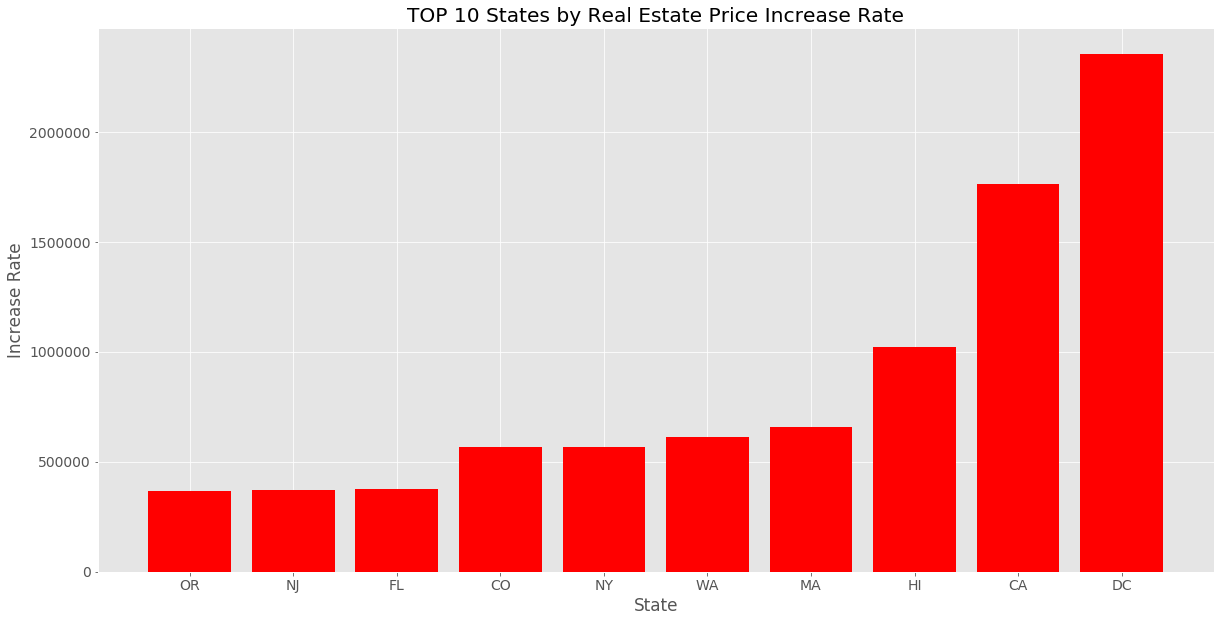

In [434]:
plt.figure(figsize = (20,10))
plt.bar(top10_state.index, top10_state['criteria'] , color='red')
plt.title('TOP 10 States by Real Estate Price Increase Rate')
plt.xlabel('State')
plt.ylabel('Increase Rate')

In [435]:
top10_state=top10_state.drop(['increase', 'increase_rate','criteria'], axis=1)
top10_state=top10_state.T


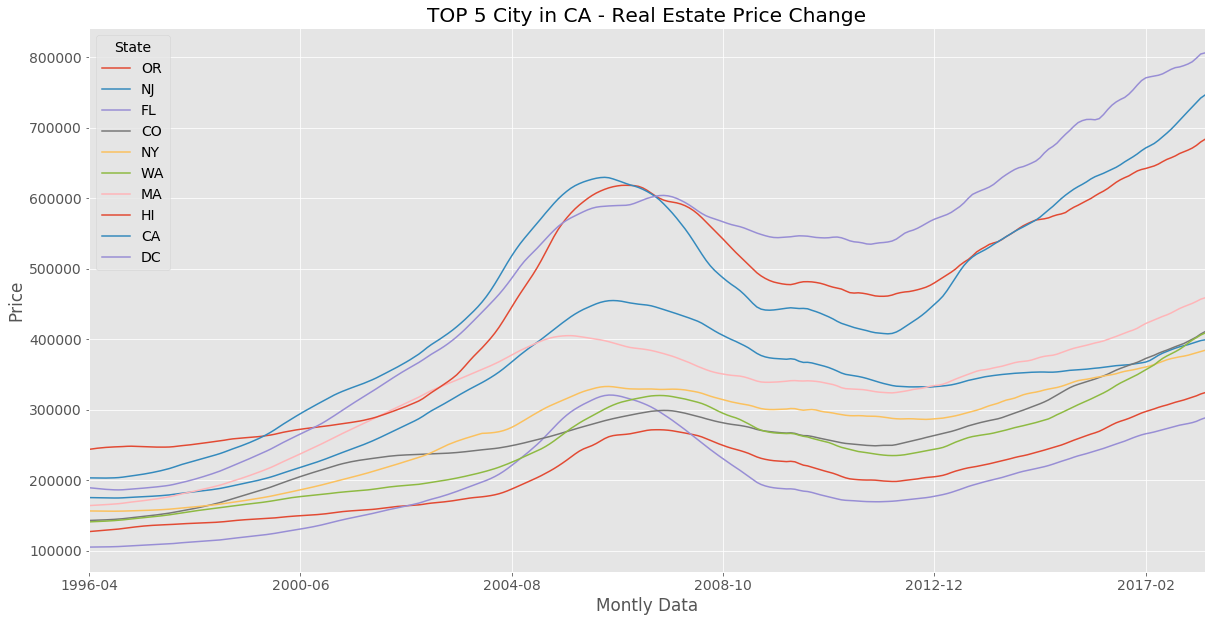

In [436]:
top10_state.plot(figsize = (20,10), subplots=False, legend=True)
plt.title('TOP 5 City in CA - Real Estate Price Change')
plt.xlabel('Montly Data')
plt.ylabel('Price')
plt.show()

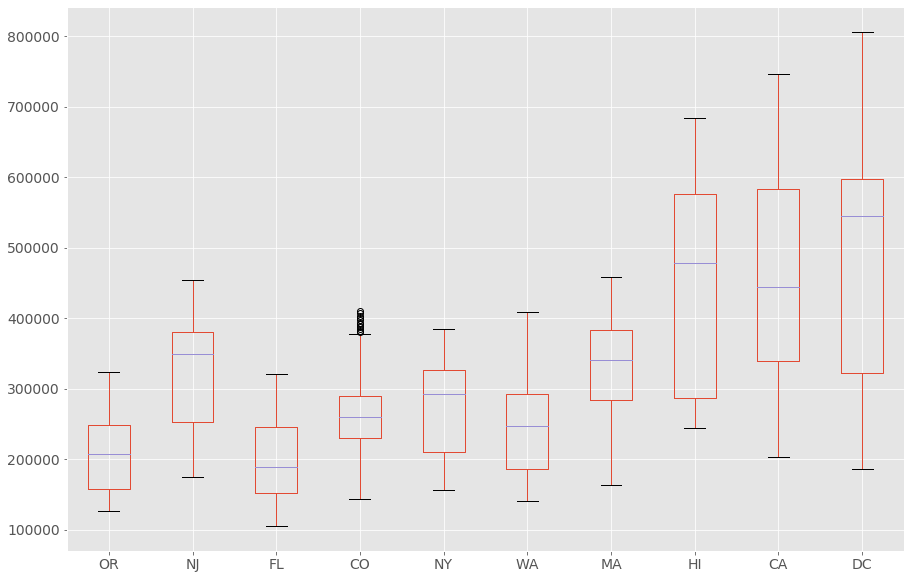

In [437]:
top10_state.boxplot(figsize = (15,10))
plt.show()


### Possible reasons behind California and DC's significant lead

#### DC

In [438]:
#I would like to see how why California is so different than the others.
df_full_DC= df_full_2[df_full_2['State']=='DC']
df_full_DC = df_full_DC.drop(['RegionID', 'CountyName','Metro','SizeRank','State'],axis=1)
DC_city=df_full_DC.set_index('City').astype(float).groupby('City').mean().sort_values('criteria')

In [439]:
DC_city

,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,...,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,increase,increase_rate,criteria
City,,,,,,,,,,,,,,,,,,,,,
Washington,189216.666667,188611.111111,188011.111111,187438.888889,186900.0,186494.444444,186222.222222,186116.666667,186305.555556,186750.0,...,786261.111111,788122.222222,790450.0,793622.222222,798838.888889,804600.0,806166.666667,616950.0,3.730675,2.355361e+06


In [440]:
#There is only one city in DC area so lets check the zipcodes instead
DC_zips=df_full_2[df_full_2['State']=='DC'].sort_values('criteria').drop(['City','RegionID', 'CountyName','Metro','SizeRank','State','increase', 'increase_rate','criteria'], axis=1)
DC_zips.tail(5)

,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
RegionName,,,,,,,,,,,,,,,,,,,,,
20003,130000,130100,130200,130400,130600,130900,131400,131900,132700,133700,...,801000,807200,811900,813400,814600,814600,815300,817300,820200,820200
20002,94300,94000,93700,93600,93400,93400,93400,93600,94000,94500,...,662800,668000,672200,673100,674600,678200,680900,683000,687500,691300
20010,110500,111200,112000,112900,113800,114900,116100,117400,118800,120400,...,732800,741700,750900,756300,759300,761800,763500,767800,774700,778200
20009,178800,179200,179600,180000,180300,180700,181200,181800,182600,183700,...,1020000,1027500,1034300,1040500,1047400,1055400,1065900,1076400,1081000,1078200
20001,92000,92600,93200,93900,94600,95400,96100,96800,97700,98600,...,765000,768800,771200,773300,777600,780500,781600,785500,791400,793300


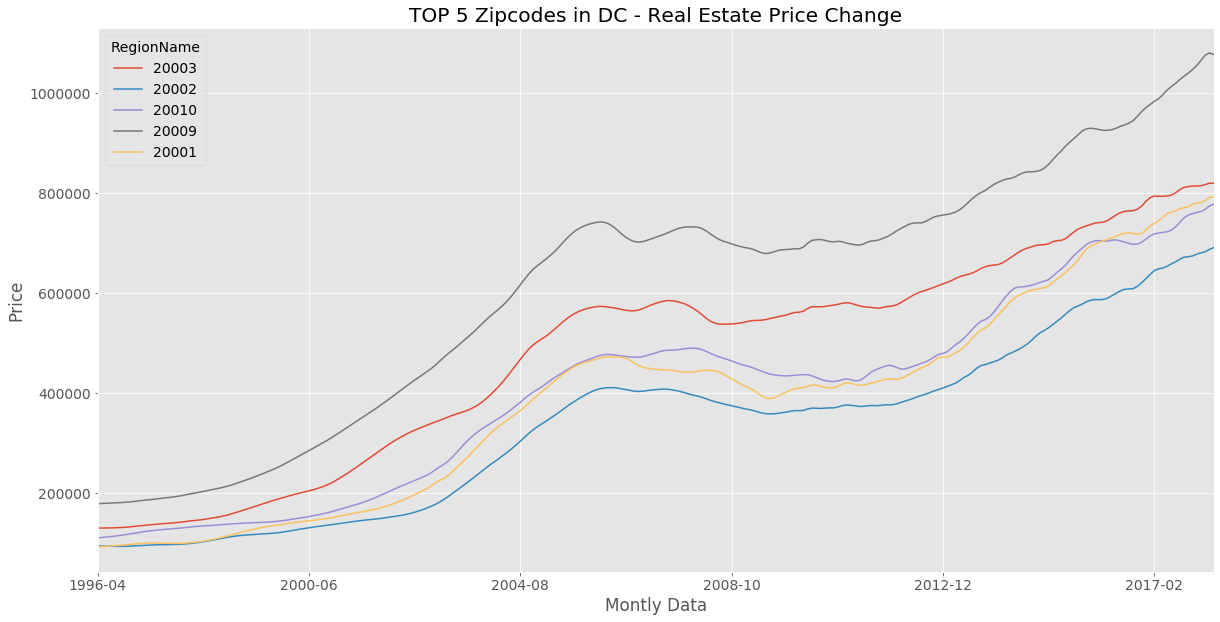

In [441]:
DC_zips.tail(5).T.plot(figsize = (20,10), subplots=False, legend=True)
 plt.title('TOP 5 Zipcodes in DC - Real Estate Price Change')
plt.xlabel('Montly Data')
plt.ylabel('Price')
plt.show()

All 5 zipcodes are around the White House. It makes total sense that real estate price did not drop much even in 2012. It has a positive trend. So we can say that, being a political hub is the key for the increase in DC.

#### California

In [442]:
#I would like to see how why California is so different than the others.
df_full_CA= df_full_2[df_full_2['State']=='CA']
df_full_CA = df_full_CA.drop(['RegionID', 'CountyName','Metro','SizeRank','State'],axis=1)
ca_city=df_full_CA.set_index('City').astype(float).groupby('City').mean().sort_values('criteria')

In [443]:
ca_city

,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,...,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,increase,increase_rate,criteria
City,,,,,,,,,,,,,,,,,,,,,
Clearlake Oaks,1.823000e+05,1.823000e+05,182300.0,1.823000e+05,1.823000e+05,1.823000e+05,1.823000e+05,1.823000e+05,1.823000e+05,1.823000e+05,...,1.827000e+05,1.843000e+05,1.841000e+05,1.836000e+05,1.846000e+05,1.855000e+05,1.860000e+05,3.700000e+03,0.020296,7.509600e+01
Portola,1.420000e+05,1.407000e+05,139300.0,1.379000e+05,1.366000e+05,1.355000e+05,1.344000e+05,1.330000e+05,1.319000e+05,1.316000e+05,...,1.368000e+05,1.395000e+05,1.433000e+05,1.451000e+05,1.453000e+05,1.452000e+05,1.460000e+05,4.000000e+03,0.028169,1.126761e+02
Hidden Valley Lake,2.900000e+05,2.900000e+05,290000.0,2.900000e+05,2.900000e+05,2.900000e+05,2.900000e+05,2.900000e+05,2.900000e+05,2.900000e+05,...,2.900000e+05,2.889000e+05,2.899000e+05,2.910000e+05,2.931000e+05,2.970000e+05,3.003000e+05,1.030000e+04,0.035517,3.658276e+02
Middletown,2.260000e+05,2.260000e+05,226000.0,2.260000e+05,2.260000e+05,2.260000e+05,2.260000e+05,2.260000e+05,2.260000e+05,2.260000e+05,...,1.933000e+05,1.954000e+05,1.994000e+05,2.013000e+05,2.030000e+05,2.074000e+05,2.130000e+05,-1.300000e+04,-0.057522,7.477876e+02
Kelseyville,2.508000e+05,2.508000e+05,250800.0,2.508000e+05,2.508000e+05,2.508000e+05,2.508000e+05,2.508000e+05,2.508000e+05,2.508000e+05,...,2.612000e+05,2.623000e+05,2.634000e+05,2.638000e+05,2.646000e+05,2.668000e+05,2.693000e+05,1.850000e+04,0.073764,1.364633e+03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
West Hollywood,5.336000e+05,5.359000e+05,538200.0,5.405000e+05,5.430000e+05,5.458000e+05,5.490000e+05,5.525000e+05,5.571000e+05,5.626000e+05,...,3.043100e+06,3.073000e+06,3.087500e+06,3.103000e+06,3.121000e+06,3.143300e+06,3.155900e+06,2.622300e+06,4.914355,1.288691e+07
Beverly Hills,7.097000e+05,7.123333e+05,715000.0,7.176333e+05,7.204667e+05,7.235333e+05,7.273333e+05,7.316000e+05,7.371333e+05,7.437333e+05,...,3.670100e+06,3.711967e+06,3.758667e+06,3.801433e+06,3.840667e+06,3.880300e+06,3.899300e+06,3.189600e+06,4.481178,1.452882e+07
Los Altos,7.039000e+05,7.061500e+05,708650.0,7.114500e+05,7.146000e+05,7.182500e+05,7.228500e+05,7.283000e+05,7.355000e+05,7.442500e+05,...,3.593250e+06,3.675950e+06,3.742050e+06,3.790200e+06,3.847550e+06,3.922350e+06,3.967600e+06,3.263700e+06,4.657659,1.515055e+07


California is a large state. While there is a significant increase in some cities, there is also decrease in the average real estate price in other cities. Lets look at the best 5 cities price change over time. 

In [444]:
plot_ca=(ca_city.tail(5).drop(['increase', 'increase_rate','criteria'], axis=1))
plot_ca

,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
City,,,,,,,,,,,,,,,,,,,,,
West Hollywood,5.336000e+05,5.359000e+05,538200.0,5.405000e+05,5.430000e+05,5.458000e+05,5.490000e+05,5.525000e+05,5.571000e+05,5.626000e+05,...,2.936800e+06,2.959000e+06,2.998700e+06,3.043100e+06,3.073000e+06,3.087500e+06,3.103000e+06,3.121000e+06,3.143300e+06,3.155900e+06
Beverly Hills,7.097000e+05,7.123333e+05,715000.0,7.176333e+05,7.204667e+05,7.235333e+05,7.273333e+05,7.316000e+05,7.371333e+05,7.437333e+05,...,3.554833e+06,3.591567e+06,3.630600e+06,3.670100e+06,3.711967e+06,3.758667e+06,3.801433e+06,3.840667e+06,3.880300e+06,3.899300e+06
Los Altos,7.039000e+05,7.061500e+05,708650.0,7.114500e+05,7.146000e+05,7.182500e+05,7.228500e+05,7.283000e+05,7.355000e+05,7.442500e+05,...,3.389500e+06,3.447800e+06,3.516000e+06,3.593250e+06,3.675950e+06,3.742050e+06,3.790200e+06,3.847550e+06,3.922350e+06,3.967600e+06
Palo Alto,5.081333e+05,5.098333e+05,511900.0,5.143667e+05,5.172333e+05,5.206000e+05,5.246000e+05,5.292667e+05,5.349333e+05,5.416333e+05,...,3.135433e+06,3.176967e+06,3.238067e+06,3.312267e+06,3.380133e+06,3.426500e+06,3.461567e+06,3.512100e+06,3.575667e+06,3.612467e+06
Atherton,1.179200e+06,1.184300e+06,1189700.0,1.195400e+06,1.201200e+06,1.207300e+06,1.214100e+06,1.221200e+06,1.230900e+06,1.242600e+06,...,6.138300e+06,6.197800e+06,6.250200e+06,6.315400e+06,6.429100e+06,6.581800e+06,6.705000e+06,6.764600e+06,6.788400e+06,6.796500e+06


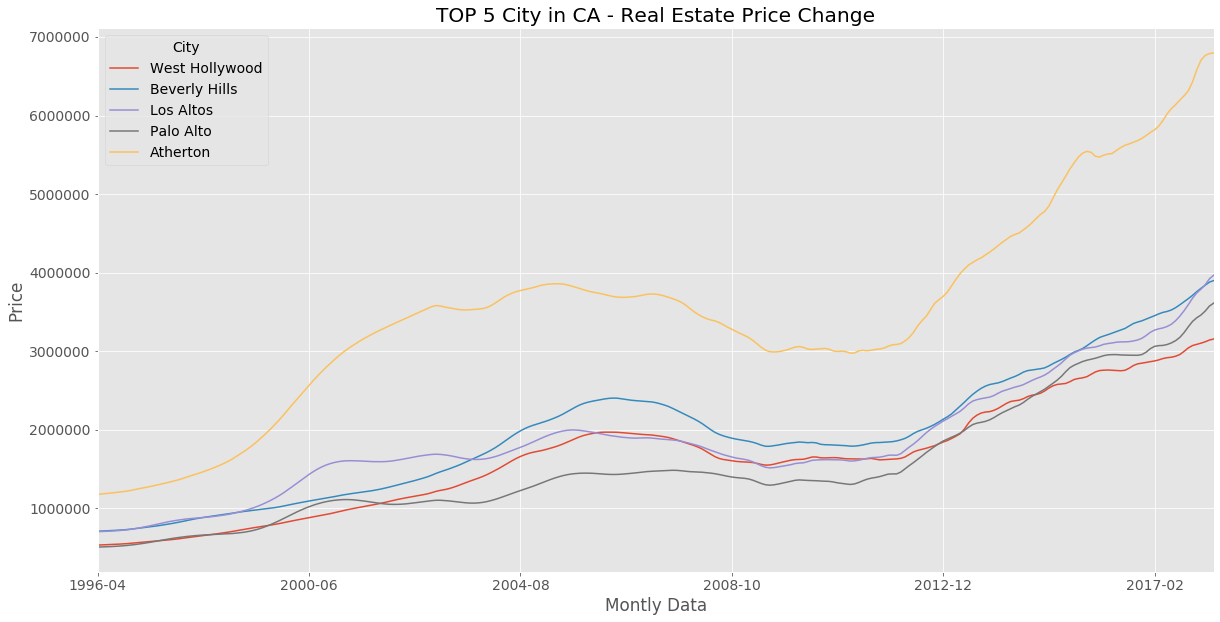

In [445]:
(plot_ca.T).plot(figsize = (20,10), subplots=False, legend=True)
plt.title('TOP 5 City in CA - Real Estate Price Change')
plt.xlabel('Montly Data')
plt.ylabel('Price')
plt.show()

Those five cities along with surrounding cities have been exceptionally well worthed investment area in CA. There are **two main reason** for the high increase we observe here. One is most of the **high technology companies** clustered in the area called **Silicon Valley**. 3 of the top 5 cities in Silicon Valley and the other reason is most likely **Hollywood**. Beverly Hills and West Hollywood are where most of the celebrities purchase extremely  expensive real estates.

In [446]:
plot_ca['2012-01']

City
West Hollywood    1.630400e+06
Beverly Hills     1.859100e+06
Los Altos         1.676050e+06
Palo Alto         1.439733e+06
Atherton          3.086600e+06
Name: 2012-01, dtype: float64

Real estates in top 5 cities in Silicon Valley used to range averagely 1M -1.5M in 2012. It now 2M-3.6M. I would like to run similar analysis for Texas since the company would like to invest on this state.


### Top 5 Cities in Texas

In [447]:
df_full_TX= df_full_2[df_full_2['State']=='TX']
df_full_TX = df_full_TX.drop(['RegionID', 'CountyName','Metro','SizeRank','State'],axis=1)
TX_city=df_full_TX.set_index('City').astype(float).groupby('City').agg(np.mean).sort_values('criteria')

In [448]:
TX_city.tail(5)

,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,...,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,increase,increase_rate,criteria
City,,,,,,,,,,,,,,,,,,,,,
Luling,25000.000000,25200.000000,25500.000000,25800.000000,26100.000000,26400.000000,26800.000000,27100.000000,27500.000000,27900.000000,...,1.023000e+05,1.024000e+05,1.030000e+05,1.033000e+05,1.041000e+05,1.059000e+05,1.070000e+05,82000.000000,3.280000,268960.000000
Paige,54300.000000,55000.000000,55700.000000,56300.000000,57000.000000,57700.000000,58400.000000,59100.000000,59800.000000,60500.000000,...,1.728000e+05,1.735000e+05,1.751000e+05,1.758000e+05,1.773000e+05,1.814000e+05,1.857000e+05,131400.000000,2.419890,317973.480663
Austin,217871.052632,217673.684211,217610.526316,217657.894737,217792.105263,217992.105263,218194.736842,218452.631579,218655.263158,218773.684211,...,3.904026e+05,3.922605e+05,3.938789e+05,3.953237e+05,3.977868e+05,4.017658e+05,4.044974e+05,186626.315789,1.312372,337641.069417
Martindale,68600.000000,69000.000000,69400.000000,69900.000000,70300.000000,70800.000000,71400.000000,71900.000000,72600.000000,73300.000000,...,2.152000e+05,2.165000e+05,2.171000e+05,2.177000e+05,2.195000e+05,2.216000e+05,2.223000e+05,153700.000000,2.240525,344368.658892
University Park,640100.000000,637000.000000,634200.000000,631800.000000,630200.000000,629300.000000,629300.000000,630200.000000,631600.000000,633600.000000,...,1.246400e+06,1.245700e+06,1.245900e+06,1.250200e+06,1.258300e+06,1.265800e+06,1.268600e+06,628500.000000,0.981878,617110.217154


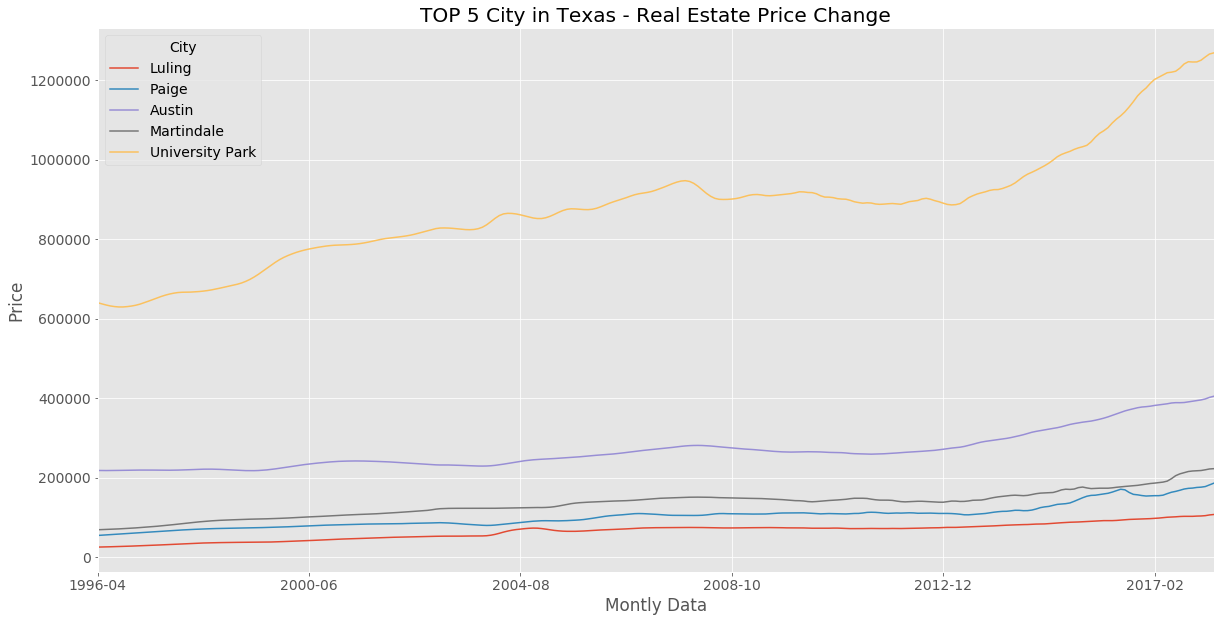

In [449]:
plot_tx=(TX_city.tail(5).drop(['increase', 'increase_rate', 'criteria'], axis=1))
(plot_tx.T).plot(figsize = (20,10), subplots=False, legend=True)
plt.title('TOP 5 City in Texas - Real Estate Price Change')
plt.xlabel('Montly Data')
plt.ylabel('Price')
plt.show()

University Park is a small city where University of North Texas is located. Probably because of that surrounding area estates has been very expensive and the price keep increasing.
Austin started increasing trend since 2012 and seem taking off. 
Now lets see what is the best 10 zipcodes in Texas area.


### Top 10 zipcodes in Texas

In [450]:
# Filter Texas data and slice top ten zipcodes
top10_rate, df_full_2= select_state_top10 (df_full, 'TX')
top10_rate.head(3)
top10_rate.head()

,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,...,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,increase,increase_rate,criteria
RegionName,,,,,,,,,,,,,,,,,,,,,
78702,55600,56700,57900,59300,60800,62500,64300,66200,68200,70300,...,397100,400600,405200,410100,413800,417300,419800,364200,6,2385641
78722,76200,76400,76500,76700,77000,77200,77600,78100,78700,79300,...,399300,400900,403300,405200,408400,413900,417500,341300,4,1528683
78751,115900,116900,118000,119100,120200,121100,122000,122700,123500,124300,...,429600,432500,434500,436100,437600,441200,444500,328600,2,931647
78703,355200,351300,347800,344900,342400,340700,339900,340400,341300,342800,...,870600,877900,876700,875900,880100,884600,885300,530100,1,791120
78721,69200,68800,68400,68100,67800,67700,67600,67600,67800,68100,...,284000,288500,293000,296300,297800,297200,296100,226900,3,743982


In [451]:
#convert the data
ts_top10_rate = convert_to_ts (top10_rate)


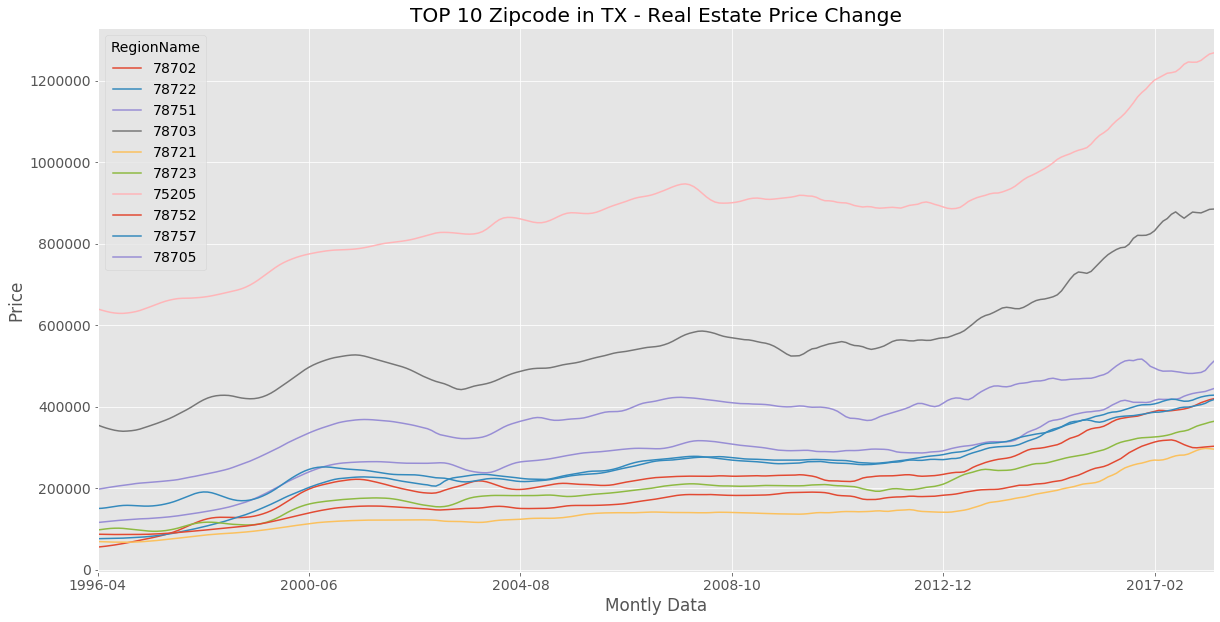

In [452]:
top10_rate.drop(['increase', 'increase_rate', 'criteria'], axis=1).T.plot(figsize = (20,10), subplots=False, legend=True)
plt.title('TOP 10 Zipcode in TX - Real Estate Price Change')
plt.xlabel('Montly Data')
plt.ylabel('Price')
plt.show()

9 out of 10 Zipcodes are in Austin and the other one in University Park. It is not surprising because Austin has been one of the fastest growing city in US. 

In [453]:
#top10_rate.T.boxplot(figsize = (15,10))
#plt.show()

### Preferable investment amount per purchase

In [454]:
print("Average investment belove 500K ", round(top10_rate[top10_rate['2018-04']<500000]['2018-04'].mean(),0))
print("Growth rate for the past 12 years", round(top10_rate[top10_rate['2018-04']<500000]['increase_rate'].mean(),1))

Average investment belove 500K  381957.0
Growth rate for the past 12 years 2.9


In [455]:
print("Average investment belove 500K ", round(top10_rate[top10_rate['2018-04']>500000]['2018-04'].mean(),0))
print("Growth rate for the past 12 years", round(top10_rate[top10_rate['2018-04']>500000]['increase_rate'].mean(),1))

Average investment belove 500K  888500.0
Growth rate for the past 12 years 0.7


In [456]:
top10_rate.describe()


,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,...,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,increase,increase_rate,criteria
count,10.000000,10.000000,10.000000,10.00000,10.000000,10.000000,10.000000,10.000000,10.00000,10.000000,...,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,10.000000,10.00000,1.000000e+01
mean,184480.000000,184330.000000,184300.000000,184430.00000,184640.000000,184960.000000,185350.000000,185850.000000,186470.00000,187210.000000,...,5.169000e+05,5.192000e+05,5.214200e+05,5.238300e+05,5.271500e+05,5.313300e+05,5.339200e+05,349440.000000,2.20000,9.275442e+05
std,183003.198515,181572.575328,180261.088425,179097.70797,178220.669708,177618.093423,177379.926523,177545.100686,177860.46997,178397.137807,...,3.046073e+05,3.045473e+05,3.032751e+05,3.032645e+05,3.050831e+05,3.067293e+05,3.069651e+05,132189.444864,1.75119,5.947651e+05
min,55600.000000,56700.000000,57900.000000,59300.00000,60800.000000,62500.000000,64300.000000,66200.000000,67800.00000,68100.000000,...,2.840000e+05,2.885000e+05,2.930000e+05,2.963000e+05,2.978000e+05,2.972000e+05,2.961000e+05,215900.000000,0.00000,4.995380e+05
25%,78950.000000,79050.000000,79075.000000,79200.00000,79375.000000,79525.000000,79800.000000,80175.000000,80650.00000,81125.000000,...,3.566000e+05,3.610000e+05,3.652000e+05,3.681500e+05,3.711250e+05,3.749000e+05,3.775250e+05,269500.000000,1.00000,5.551900e+05
50%,106750.000000,107950.000000,109150.000000,110250.00000,111050.000000,111550.000000,111750.000000,111550.000000,111450.00000,111350.000000,...,4.066000e+05,4.086500e+05,4.129000e+05,4.170500e+05,4.200500e+05,4.226000e+05,4.241500e+05,321350.000000,2.00000,7.361075e+05
75%,185700.000000,187200.000000,188775.000000,190425.00000,192050.000000,193550.000000,194775.000000,195825.000000,196875.00000,197925.000000,...,4.688250e+05,4.695500e+05,4.710250e+05,4.722500e+05,4.762250e+05,4.862000e+05,4.948250e+05,358475.000000,2.75000,8.965152e+05
max,640100.000000,637000.000000,634200.000000,631800.00000,630200.000000,629300.000000,629300.000000,630200.000000,631600.00000,633600.000000,...,1.246400e+06,1.245700e+06,1.245900e+06,1.250200e+06,1.258300e+06,1.265800e+06,1.268600e+06,628500.000000,6.00000,2.385641e+06


Average increase rate is much higher for the purchases under 500K per unit. It is suggested to keep purchases in the rage of 300K - 550K 

In [457]:
ts_top10_rate.describe()

RegionName,78702,78722,78751,78703,78721,78723,75205,78752,78757,78705
count,265.000000,265.000000,265.000000,265.000000,265.000000,265.000000,2.650000e+02,265.000000,265.000000,265.000000
mean,224687.169811,246498.490566,279264.528302,551768.301887,143692.452830,198437.358491,8.802596e+05,173755.849057,263824.528302,375948.301887
std,79154.542366,82314.082050,78277.082315,127591.472442,51937.036652,63076.137859,1.437548e+05,54987.149788,68353.668923,79520.446240
min,55600.000000,76200.000000,115900.000000,339900.000000,67600.000000,94400.000000,6.293000e+05,86400.000000,150300.000000,197500.000000
25%,199000.000000,219000.000000,254400.000000,474900.000000,118700.000000,167900.000000,7.971000e+05,150200.000000,222900.000000,340100.000000
50%,220300.000000,260000.000000,290000.000000,536800.000000,138800.000000,196400.000000,8.901000e+05,172300.000000,261900.000000,385300.000000
75%,233200.000000,276200.000000,309900.000000,580400.000000,144600.000000,210400.000000,9.198000e+05,189600.000000,280000.000000,420900.000000
max,419800.000000,417500.000000,444500.000000,885300.000000,297800.000000,364200.000000,1.268600e+06,318700.000000,428500.000000,517100.000000


#### Further Work

In [458]:
#  Cut data from 2012 
#  calculate variance for risk 

#df_state_top10.plot(figsize = (20,10), subplots=False, legend=True)

"""rolmean = ts_top10_rate.rolling(window = 4).mean()
rolstd = ts_top10_rate.rolling(window = 4).std()

fig = plt.figure(figsize=(11,7))
orig = plt.plot(top10_rate, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='green', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)
"""

"rolmean = ts_top10_rate.rolling(window = 4).mean()\nrolstd = ts_top10_rate.rolling(window = 4).std()\n\nfig = plt.figure(figsize=(11,7))\norig = plt.plot(top10_rate, color='blue',label='Original')\nmean = plt.plot(rolmean, color='red', label='Rolling Mean')\nstd = plt.plot(rolstd, color='green', label='Rolling Std')\nplt.legend(loc='best')\nplt.title('Rolling Mean & Standard Deviation')\nplt.show(block=False)\n"

In [469]:
top10_rate=top10_rate.drop(['increase', 'increase_rate', 'criteria'], axis=1)

In [466]:
def plot_params(df):
    rcParams['figure.figsize'] = 15,4
    fig = plt.figure(figsize=(15,15))
    plt.subplot(411)
    ts_plot = df.plot(legend=True, label='avg prices',linewidth=1, c='b')
    plt.legend(loc='best')
    plt.subplot(412)
    ts_delta_plot = df.diff(1).plot(legend=False, label='1 lag difference',linewidth=1, c='r')
    plt.legend(loc='best')
    ts_acf_plot = plot_acf(df, title='ACF for prices')
    ts_pacf_plot = plot_pacf(df, title='PACF for prices')
    ts_pacf_plot = plot_pacf(df.diff(1).dropna(), title='PACF for delta prices');

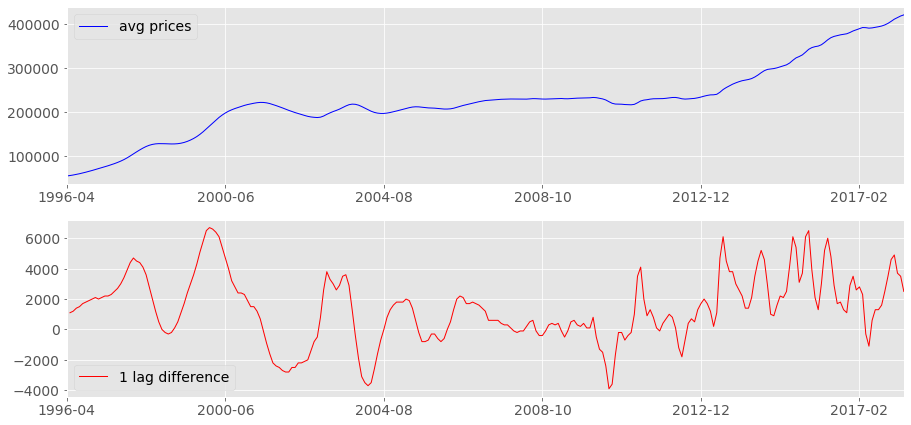

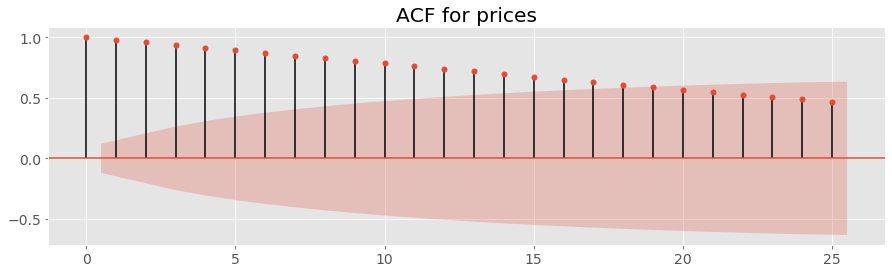

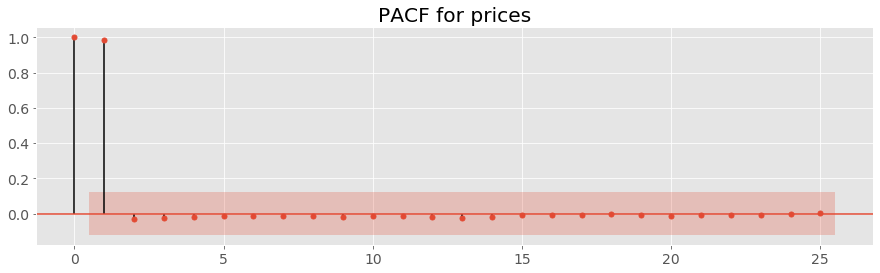

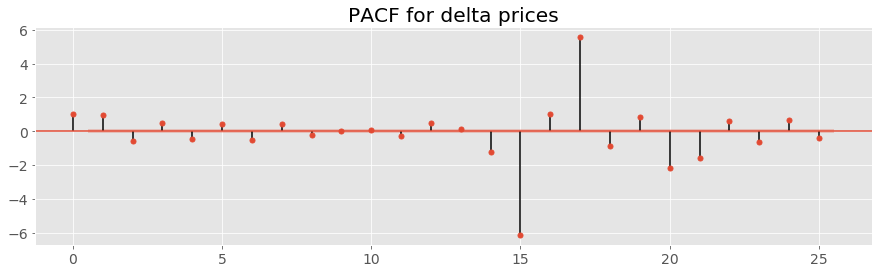

In [470]:
plot_params(top10_rate.T[78702])


### Texas trend on average price

In [ ]:
def melt_data(df):
    """return melted to long-format df with averaged prices by using groupby and mean agg-fx
input df - must be in wide format
    """
    
    melted = pd.melt(df, id_vars=['RegionName', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

In [478]:
melt_texas=pd.melt(df_full_TX, id_vars=['City', 'increase','increase_rate','criteria' ], var_name='time')

In [480]:
melt_texas['time']=pd.to_datetime(melt_texas['time'], infer_datetime_format=True)

In [491]:
melt_texas=melt_texas.dropna(subset=['value'])

melt_texas.drop(['City', 'increase','increase_rate','criteria' ], axis=1, inplace=True)

In [ ]:
plt.plot(melt_texas.index, melt_texas.time)

# DO NOT CHANGE DATAFRAME NAME AFTER THIS POINT , "ts"  is the name

### Convert data to timeseries

In [268]:
ts=ts_top10_rate
ts

RegionName,78702,78722,78751,78703,78721,78723,75205,78752,78757,78705
1996-04-01,55600,76200,115900,355200,69200,97600,640100,87200,150300,197500
1996-05-01,56700,76400,116900,351300,68800,99000,637000,87000,150900,199300
1996-06-01,57900,76500,118000,347800,68400,100300,634200,86800,152100,201000
1996-07-01,59300,76700,119100,344900,68100,101400,631800,86700,153600,202700
1996-08-01,60800,77000,120200,342400,67800,101900,630200,86500,155300,204300
...,...,...,...,...,...,...,...,...,...,...
2017-12-01,405200,403300,434500,876700,293000,352500,1245900,299300,420600,483200
2018-01-01,410100,405200,436100,875900,296300,355800,1250200,300400,424000,484300
2018-02-01,413800,408400,437600,880100,297800,358700,1258300,301400,426300,489100
2018-03-01,417300,413900,441200,884600,297200,361900,1265800,302300,427900,501200


# Step 4. Dickey Fuller Test for Stationarity Check

In [473]:

for i in ts.columns:
    X = ts[i]
    result = adfuller(X)
    print(i)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

78702
ADF Statistic: -0.361987
p-value: 0.916255
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573
78722
ADF Statistic: -0.866868
p-value: 0.798688
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573
78751
ADF Statistic: -1.194357
p-value: 0.676018
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573
78703
ADF Statistic: 0.344366
p-value: 0.979291
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573
78721
ADF Statistic: -0.271275
p-value: 0.929475
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573
78723
ADF Statistic: 0.575811
p-value: 0.987004
Critical Values:
	1%: -3.456
	5%: -2.873
	10%: -2.573
75205
ADF Statistic: 0.079278
p-value: 0.964618
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573
78752
ADF Statistic: -0.104332
p-value: 0.949005
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573
78757
ADF Statistic: 0.129974
p-value: 0.968049
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573
78705
ADF Statistic: -1.371913
p-value: 0.595665
Critical Values:
	1%: -3.457

None of the columns in the time series data is stationary. So I will use ARIMA Model since it can handle non-stationary data. I will do grid search to figure out best combinations for the necessary parameters. 

In [269]:
#small data for code testing purposes only before passing the entire ts. 
df_2=ts.iloc[:,:2]
#df_2= df_2.iloc[:3, :]
df_2
df_1=ts.iloc[:,:1]
#df_1

# Step 5: ARIMA Modelling

## Functions for Modelling and Analysing

In [193]:
def iterations ():
    p = range(0,4)
    d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))  # Generate all different combinations of p, d, q and s triplets
    pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
    return pdq, pdqs 


def grid_search (df, pdq, pdqs):
    # Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
    ans = []
    for comb in pdq:
        for combs in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(df,
                                                order=comb,
                                                seasonal_order=combs,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
                output = mod.fit()
                ans.append([comb, combs, output.aic])
                #print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
            except:
                continue

    # Find the parameters with minimal AIC value.
    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
    ans_df.loc[ans_df['aic'].idxmin()]
    # Asign the best combinations to new lists
    pdq_new=ans_df.loc[ans_df['aic'].idxmin()].pdq
    pdqs_new=ans_df.loc[ans_df['aic'].idxmin()].pdqs
    print('Best ARIMA combination {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
    return  (pdq_new, pdqs_new)


def arima (df, pdq_new, pdqs_new ):

    ARIMA_MODEL = sm.tsa.statespace.SARIMAX(df,
                                    order=pdq_new,
                                    seasonal_order=pdqs_new,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)

    output = ARIMA_MODEL.fit()
    #print(output.summary().tables[1])
    return output

def forecasting (model, steps):
    # Get forecast any steps ahead in future
    prediction = model.get_forecast(steps=steps)
    # Get confidence intervals of forecasts
    pred_conf = prediction.conf_int()
    return prediction , pred_conf


def model_tables (model):
    print(model.summary().tables[0])
    print(model.summary().tables[1])
    print(model.summary().tables[2])
    #print(model.summary())
    
def plot_diog(model):
    # Use plot_diagnostics with results calculated above.
    model.plot_diagnostics(figsize=(12, 8))
    
    

def prediction_plot(zipcode, model):
    prediction = model.get_forecast(60)
    pred_conf = prediction.conf_int()
    plt.figure(figsize=(18,8))
    plt.plot(zipcode, label='Observed Values')
    prediction.predicted_mean.plot(label='Forecast')
    plt.fill_between(pred_conf.index, pred_conf.iloc[:, 0], pred_conf.iloc[:, 1], color='grey')
    plt.title('{}'.format(zipcode.name))
    plt.ylabel('Average Real Estate Values')
    plt.xlabel('Dates')
    plt.legend();
    plt.show()
    
    
def predict (df):
    data = pd.DataFrame( columns = ['Zipcode' , 'Investment',  'forecast_3_years' , 'rate_3','3_year_min', '3_year_max',  
                                    'forecast_5_years' ,'rate_5', '5_year_min', '5_year_max', 'pdq', 'pdqs'])
    combs = []
    for i in df.columns:
        #pdq, pdqs =iterations()
        pdq_new,pdqs_new = (3,1,1), (3,1,1,12)
        #pdq_new, pdqs_new= grid_search (df[i], pdq, pdqs)
        output=arima(df[i], pdq_new, pdqs_new)
        # Get forecast any steps ahead in future
        prediction = output.get_forecast(steps=60)
        # Get confidence intervals of forecasts
        pred_conf = prediction.conf_int()
        #Get average predicted value 
        pred_conf['mean']=prediction.predicted_mean
        #Calculate increase rate for 3 and 5 years 
        increase_rate_3_years = round((pred_conf.iloc[35][2]- df[i][-1])/df[i][-1],2)
        increase_rate_5_years = round((pred_conf.iloc[59][2]- df[i][-1])/df[i][-1],2)
        # Store 36th and 60th month data points ( 3rd and 5th year)
        data=data.append(pd.Series([i,df[i][-1], round(pred_conf.iloc[35][2], 0),increase_rate_3_years, 
                               round(pred_conf.iloc[35][0],0), round(pred_conf.iloc[35][1],0), 
                             round(pred_conf.iloc[59][2],0) ,increase_rate_5_years, 
                               round(pred_conf.iloc[59][0],0) , round(pred_conf.iloc[59][1],0), pdq_new, pdqs_new], 
                                   index=data.columns ), ignore_index=True)
        #Store parameter combinations in a seperate list 
        combs.append([i, pdq_new, pdqs_new])
        
    return data, combs


def report_plot (zipcodes, combs, df, df_full):
       
        for i in zipcodes :
            for k in range(len(combs)):
                if combs[k][0]==i:
                    pdq_new=combs[k][1]
                    pdqs_new = combs[k][2]
            
            output=arima(df[i], pdq_new, pdqs_new)
            prediction , pred_conf= forecasting (output, 60)
            pred_conf['mean']=prediction.predicted_mean
            #Calculate increase rate in 3 - 5 years
            
            increase_rate_3_years = round((pred_conf.iloc[35][2]- df[i][-1])/df[i][-1],2)
            increase_rate_5_years = round((pred_conf.iloc[59][2]- df[i][-1])/df[i][-1],2)
            
            
            
            #Plot the forecasted data along with the real data
            prediction_plot(df[i], output)
            
            # Get city and the state for the zipcodes
            city=(df_full[df_full['RegionName']==i].City).to_string(index=False)
            state = df_full[df_full['RegionName']==i].State.to_string(index=False)

            print("Zipcode :" , i)
            print("City : {}".format(city))
            print("State :", state)

            print("Investment($) :", df[i][-1] )
            print("********")
            print("Predicted price in 3 years :",round(pred_conf.iloc[35][2],0) )
            print("Total Increase in 3 years :", pred_conf.iloc[35][2]- df[i][-1]) 
            print('Increase rate in 3 years (%) :', increase_rate_3_years)
            print("Possible range :", round(pred_conf.iloc[35][0],0)," - ",round(pred_conf.iloc[35][1],0) )
            print("********")
            print("Predicted price in 5 years :", round(pred_conf.iloc[59][2],0))
            print("Total Increase in 5 years :", pred_conf.iloc[59][2]- df[i][-1]) 
            print('Increase rate in 5 years (%) :', increase_rate_5_years)
            print("Possible range :", round(pred_conf.iloc[59][0],0)," - ", round(pred_conf.iloc[59][1],0) )
            print("-----------------------------------------------------------------------------")
        
            plot_diog(output)
        
        return 

### Modelling and Forecasting

In [194]:
pred_data, combs = predict(ts)

In [ ]:
#save the data in to a .csv file. 
export_csv = pred_data.to_csv ('pred_data.csv', index = None, header=True) 

### Filtering TOP 5 Zipcode from Forecasted Data

I added two columns to dataframe for the price increase within 3 years and 5 years. I sorted the data based on the percentage of price increase in the next 3 and 5 years.

In [196]:
pred_data['risk_range_3']=(pred_data['3_year_max']-pred_data['forecast_3_years'])/pred_data['forecast_3_years']
pred_data['risk_range_5']=(pred_data['5_year_max']-pred_data['forecast_5_years'])/pred_data['forecast_5_years']
pred_data.sort_values(by= ['rate_3','rate_5'], ascending=False, inplace=True)
pred_data

,Zipcode,Investment,forecast_3_years,rate_3,3_year_min,3_year_max,forecast_5_years,rate_5,5_year_min,5_year_max,pdq,pdqs,risk_range_3,risk_range_5
6,75205,1268600,1475245.0,0.16,1269124.0,1681366.0,1614455.0,0.27,1231511.0,1997400.0,"(3, 1, 1)","(3, 1, 1, 12)",0.139720,0.237198
3,78703,885300,1017537.0,0.15,769902.0,1265171.0,1107801.0,0.25,648691.0,1566911.0,"(3, 1, 1)","(3, 1, 1, 12)",0.243366,0.414434
7,78752,303100,344202.0,0.14,277373.0,411031.0,365730.0,0.21,270887.0,460573.0,"(3, 1, 1)","(3, 1, 1, 12)",0.194156,0.259325
9,78705,511600,579046.0,0.13,418769.0,739322.0,620724.0,0.21,316874.0,924575.0,"(3, 1, 1)","(3, 1, 1, 12)",0.276793,0.489511
0,78702,419800,465739.0,0.11,378902.0,552577.0,500701.0,0.19,376497.0,624906.0,"(3, 1, 1)","(3, 1, 1, 12)",0.186452,0.248062
1,78722,417500,463557.0,0.11,386359.0,540756.0,493872.0,0.18,382721.0,605022.0,"(3, 1, 1)","(3, 1, 1, 12)",0.166536,0.225058
2,78751,444500,488822.0,0.10,402476.0,575168.0,518393.0,0.17,396139.0,640647.0,"(3, 1, 1)","(3, 1, 1, 12)",0.176641,0.235833
5,78723,364200,399504.0,0.10,337874.0,461134.0,424819.0,0.17,338066.0,511572.0,"(3, 1, 1)","(3, 1, 1, 12)",0.154266,0.204212
8,78757,428500,473282.0,0.10,406813.0,539750.0,503325.0,0.17,401396.0,605254.0,"(3, 1, 1)","(3, 1, 1, 12)",0.140441,0.202511
4,78721,296100,315650.0,0.07,255036.0,376264.0,332669.0,0.12,243837.0,421502.0,"(3, 1, 1)","(3, 1, 1, 12)",0.192029,0.267031


I extracted the top 5 Zipcodes from the prediction data. I only need the zipcodes so I store them in a series to use in the detailed plot function. 

In [198]:
#get top 5 zipcodes
zipcodes=list(pred_data.iloc[:5,:].Zipcode)
zipcodes

[75205, 78703, 78752, 78705, 78702]

### Detailed Report for TOP 5 Zipcodes


In this part, I use top 5 zipcodes series, their best parameter combinations to run the model one more time and create plot for the historical data and forcasted data. It also shades the predictions confidence interval. At the bottom of each plot, there is a detailed report for that zipcode. Last set of plots are the plot diagnostics with results calculated in the model. 

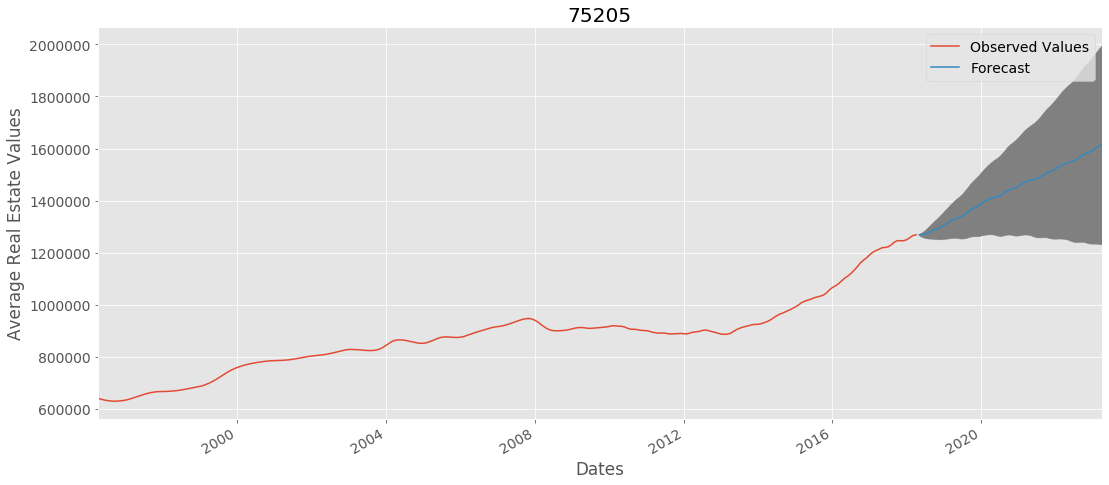

Zipcode : 75205
City :  University Park
State :  TX
Investment($) : 1268600
********
Predicted price in 3 years : 1475245.0
Total Increase in 3 years : 206644.6278622318
Increase rate in 3 years (%) : 0.16
Possible range : 1269124.0  -  1681366.0
********
Predicted price in 5 years : 1614455.0
Total Increase in 5 years : 345855.4514563428
Increase rate in 5 years (%) : 0.27
Possible range : 1231511.0  -  1997400.0
-----------------------------------------------------------------------------


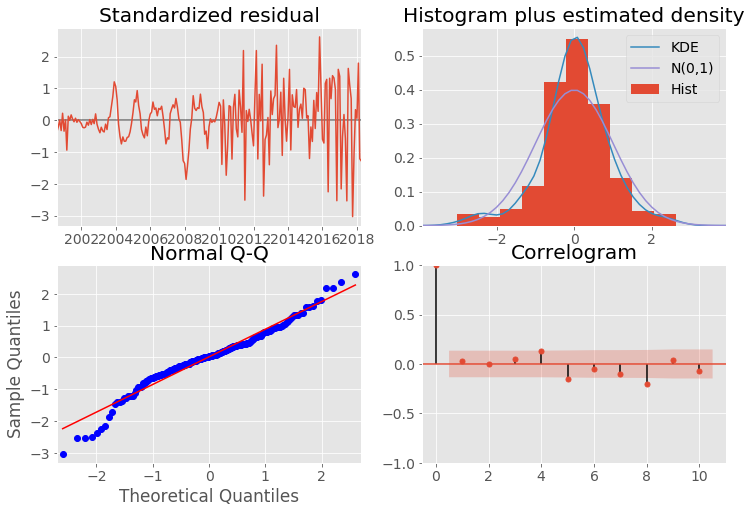

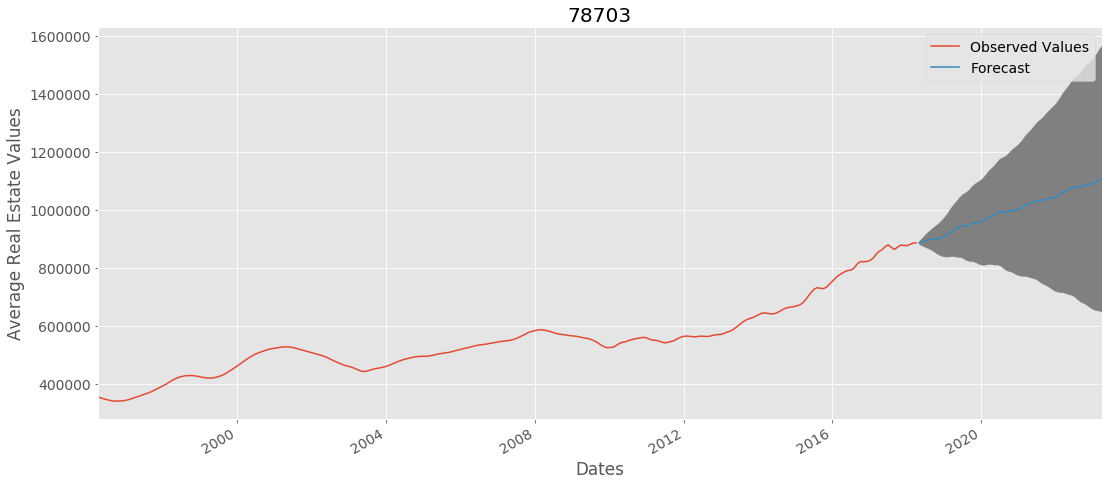

Zipcode : 78703
City :  Austin
State :  TX
Investment($) : 885300
********
Predicted price in 3 years : 1017537.0
Total Increase in 3 years : 132236.75707111566
Increase rate in 3 years (%) : 0.15
Possible range : 769902.0  -  1265171.0
********
Predicted price in 5 years : 1107801.0
Total Increase in 5 years : 222501.1103660022
Increase rate in 5 years (%) : 0.25
Possible range : 648691.0  -  1566911.0
-----------------------------------------------------------------------------


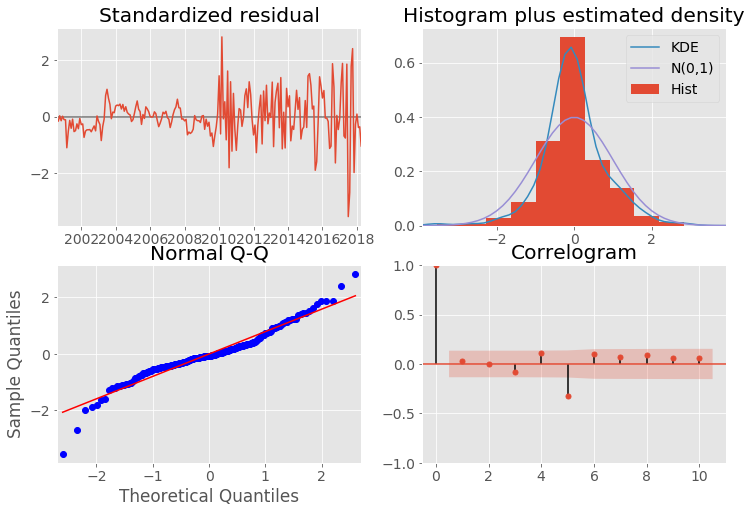

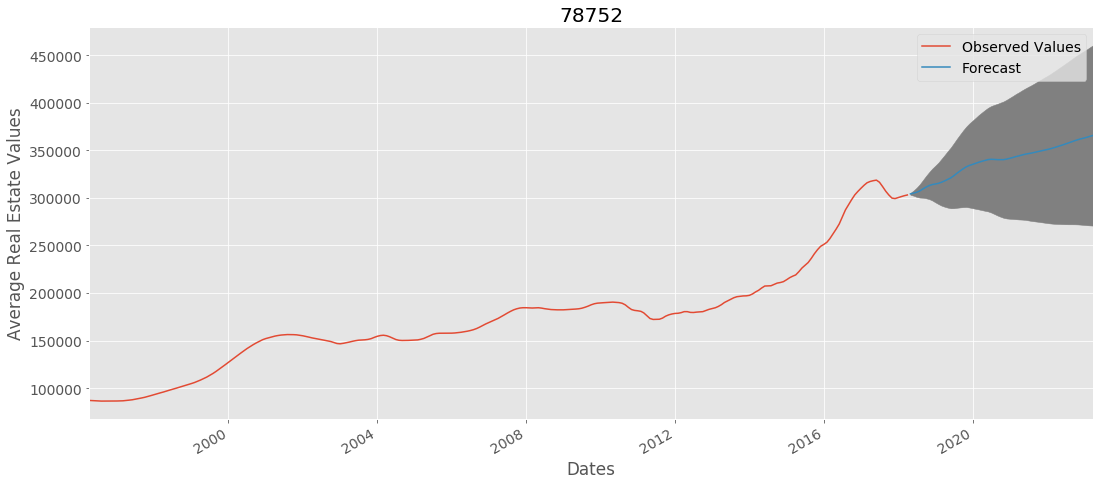

Zipcode : 78752
City :  Austin
State :  TX
Investment($) : 303100
********
Predicted price in 3 years : 344202.0
Total Increase in 3 years : 41101.91920394637
Increase rate in 3 years (%) : 0.14
Possible range : 277373.0  -  411031.0
********
Predicted price in 5 years : 365730.0
Total Increase in 5 years : 62630.009648325795
Increase rate in 5 years (%) : 0.21
Possible range : 270887.0  -  460573.0
-----------------------------------------------------------------------------


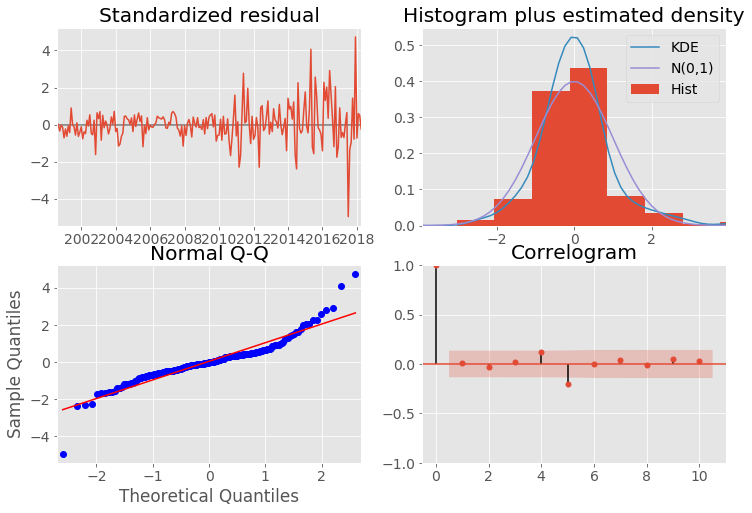

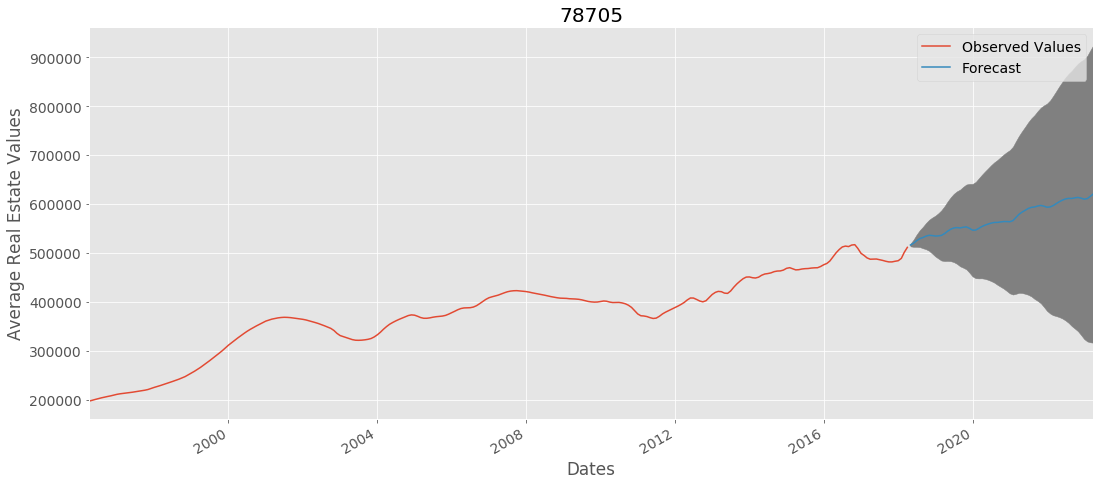

Zipcode : 78705
City :  Austin
State :  TX
Investment($) : 511600
********
Predicted price in 3 years : 579046.0
Total Increase in 3 years : 67445.6498745163
Increase rate in 3 years (%) : 0.13
Possible range : 418769.0  -  739322.0
********
Predicted price in 5 years : 620724.0
Total Increase in 5 years : 109124.49414792378
Increase rate in 5 years (%) : 0.21
Possible range : 316874.0  -  924575.0
-----------------------------------------------------------------------------


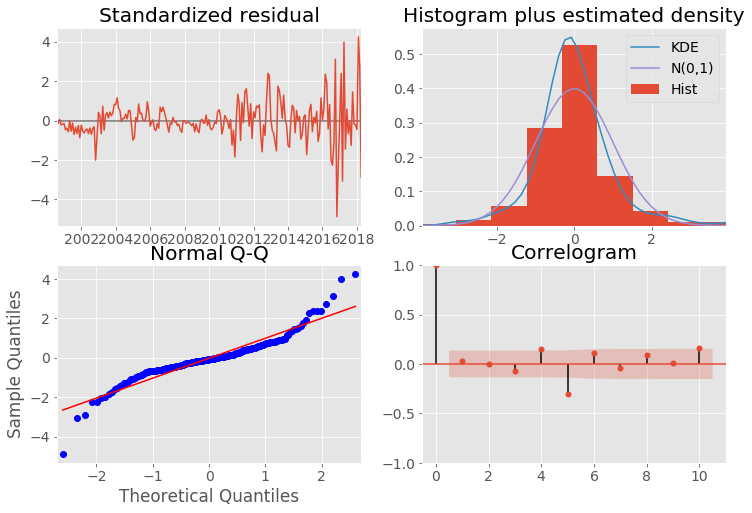

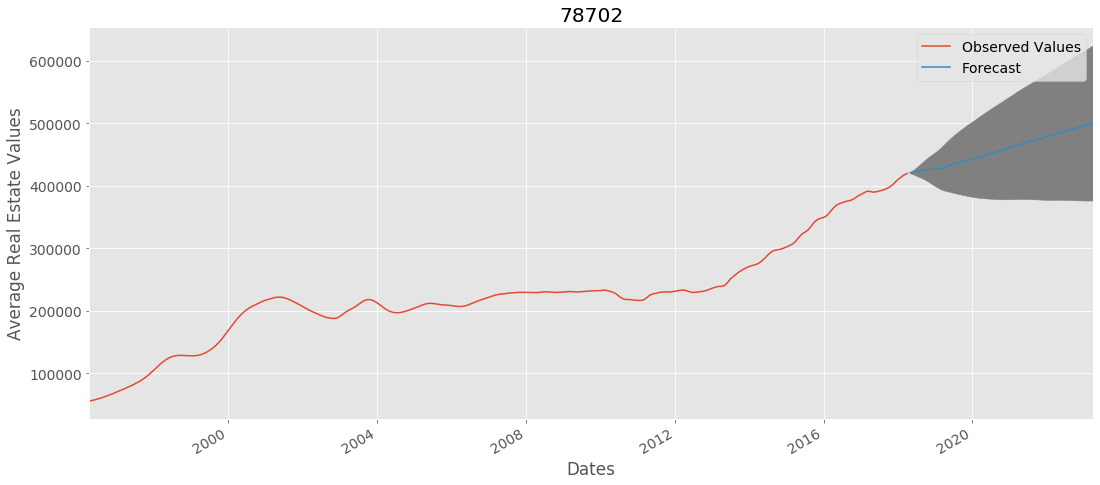

Zipcode : 78702
City :  Austin
State :  TX
Investment($) : 419800
********
Predicted price in 3 years : 465739.0
Total Increase in 3 years : 45939.44208856288
Increase rate in 3 years (%) : 0.11
Possible range : 378902.0  -  552577.0
********
Predicted price in 5 years : 500701.0
Total Increase in 5 years : 80901.41068622377
Increase rate in 5 years (%) : 0.19
Possible range : 376497.0  -  624906.0
-----------------------------------------------------------------------------


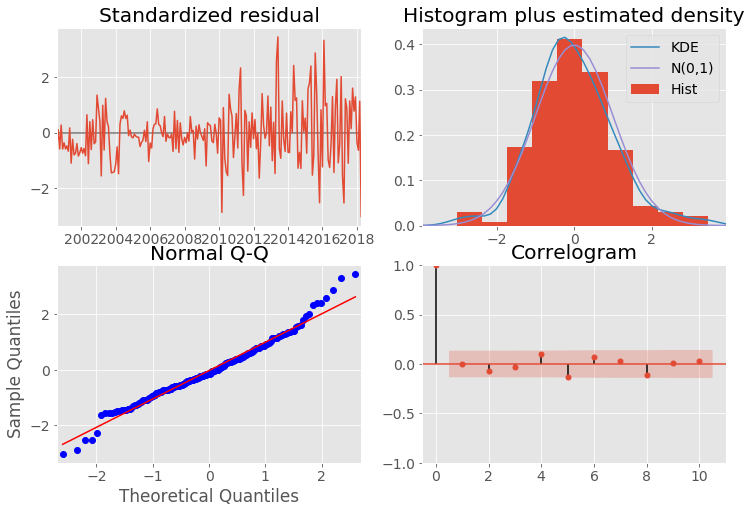

In [199]:
report_plot (zipcodes, combs, ts, df)

#Calculate increase rate in 3 - 5 years
#Plot the forecasted data along with the real data


#### Assumptions for the model have met

From the diognostics plot, we can see if the assumptions met to make sure the model works properly.Residuals resamble white noise and it's KDE has normal distribution with mean 0 and standard deviation of 1.Also,  the qq-plot shows that the ordered distribution of residuals mostly follows the linear trend of the samples taken from a standard normal distribution These indicate that the residuals are normally distributed. Correlogram shows that the time series residuals have low correlation with lagged versions of itself.

According to the plots above, all columns seem met the assumptions. KDE histogram and Q-Q plot indicates some outliers in a few zipcodes, that makes the confidence interval wider.But data seem too be ok for this model mostly.   


### Creating Result Tables

In [200]:
# Add City, 
report=pred_data.iloc[:5,:]
city=[]
state=[]
metro=[]
for i in zipcodes:
    city.append(df[df.RegionName==i].City.to_string(index=False))
    state.append(df[df.RegionName==i].State.to_string(index=False))  
    metro.append(df[df.RegionName==i].Metro.to_string(index=False))  
report['State'] = state
report['City'] = city
report['Metro'] = metro

report_3_yrs= report[['Zipcode',"City", "State","Metro", 'Investment', 'forecast_3_years', "rate_3", 
                      "3_year_min", "3_year_max", "risk_range_3"]]
report_5_yrs= report[['Zipcode',"City", "State","Metro", 'Investment', 'forecast_5_years', "rate_5", 
                      "5_year_min", "5_year_max", "risk_range_5"]]


In [201]:
report_3_yrs.columns=['Zipcode',"City", "State","Metro", 'Investment', 'Price_in_3_yrs', "Growth_Rate", 
                      "Predict_min", "Predict_max", "Risk_Rate"]
report_3_yrs



,Zipcode,City,State,Metro,Investment,Price_in_3_yrs,Growth_Rate,Predict_min,Predict_max,Risk_Rate
6,75205,University Park,TX,Dallas-Fort Worth,1268600,1475245.0,0.16,1269124.0,1681366.0,0.139720
3,78703,Austin,TX,Austin,885300,1017537.0,0.15,769902.0,1265171.0,0.243366
7,78752,Austin,TX,Austin,303100,344202.0,0.14,277373.0,411031.0,0.194156
9,78705,Austin,TX,Austin,511600,579046.0,0.13,418769.0,739322.0,0.276793
0,78702,Austin,TX,Austin,419800,465739.0,0.11,378902.0,552577.0,0.186452


In [202]:
report_5_yrs.columns=['Zipcode',"City", "State", "Metro",'Investment', 'Price_in_5_yrs', "Growth_Rate", 
                      "Predict_min", "Predict_max", "Risk_Rate"]
report_5_yrs



,Zipcode,City,State,Metro,Investment,Price_in_5_yrs,Growth_Rate,Predict_min,Predict_max,Risk_Rate
6,75205,University Park,TX,Dallas-Fort Worth,1268600,1614455.0,0.27,1231511.0,1997400.0,0.237198
3,78703,Austin,TX,Austin,885300,1107801.0,0.25,648691.0,1566911.0,0.414434
7,78752,Austin,TX,Austin,303100,365730.0,0.21,270887.0,460573.0,0.259325
9,78705,Austin,TX,Austin,511600,620724.0,0.21,316874.0,924575.0,0.489511
0,78702,Austin,TX,Austin,419800,500701.0,0.19,376497.0,624906.0,0.248062


# Step 6: Modelling with Facebook Prophet

In [203]:
#Convert the data the format that fbprophet needs (add ds column with the dates)
ts['ds'] = ts.index
ts


RegionName,78702,78722,78751,78703,78721,78723,75205,78752,78757,78705,ds
1996-04-01,55600,76200,115900,355200,69200,97600,640100,87200,150300,197500,1996-04-01
1996-05-01,56700,76400,116900,351300,68800,99000,637000,87000,150900,199300,1996-05-01
1996-06-01,57900,76500,118000,347800,68400,100300,634200,86800,152100,201000,1996-06-01
1996-07-01,59300,76700,119100,344900,68100,101400,631800,86700,153600,202700,1996-07-01
1996-08-01,60800,77000,120200,342400,67800,101900,630200,86500,155300,204300,1996-08-01
...,...,...,...,...,...,...,...,...,...,...,...
2017-12-01,405200,403300,434500,876700,293000,352500,1245900,299300,420600,483200,2017-12-01
2018-01-01,410100,405200,436100,875900,296300,355800,1250200,300400,424000,484300,2018-01-01
2018-02-01,413800,408400,437600,880100,297800,358700,1258300,301400,426300,489100,2018-02-01
2018-03-01,417300,413900,441200,884600,297200,361900,1265800,302300,427900,501200,2018-03-01


In [204]:
from fbprophet import Prophet as proph
def prophet_prediction(df, topzips):
    dscol = [x for x in df.ds]
    
    values = []
    
    for i in topzips:
        ycol = [x for x in df[i]]
        
        ts = pd.DataFrame()
        ts['ds'] = dscol
        ts['y'] = ycol
        
        Model = proph(interval_width=0.95)
        Model.fit(ts)
        
        future_dates = Model.make_future_dataframe(periods=36, freq='MS')
        forecast = Model.predict(future_dates)
        
        forecasted_data=forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
        
        increase_3_yrs = round(forecast['yhat'][300] - forecast['yhat'][264], 2)
        increase_rate_3 = round(increase_3_yrs / forecast['yhat'][264], 2)
                                                        
        values.append((i, df[i][-1], increase_3_yrs, increase_rate_3))
        
        
        Model.plot(forecast, uncertainty=True)
        plt.title(i)
        plt.ylabel('Real Estate Value')
        plt.xlabel('Year')
        Model.plot_components(forecast)
        plt.title(i)
        plt.ylabel('Real Estate Value')
        plt.xlabel('Yearly Trend');
        
        
       
        print("Zipcode :" , i)
        print("Investment($) :", df[i][-1] )
        print("********")
        print("Predicted price in 3 years :",round(forecast['yhat'][300] ))
        print('Increase rate in 3 years (%) :',  increase_rate_3 )
        print("-----------------------------------------------------------------------------")    
        
    return values , forecasted_data

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Zipcode : 75205
Investment($) : 1268600
********
Predicted price in 3 years : 1534000.0
Increase rate in 3 years (%) : 0.2
-----------------------------------------------------------------------------


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Zipcode : 78703
Investment($) : 885300
********
Predicted price in 3 years : 1105883.0
Increase rate in 3 years (%) : 0.22
-----------------------------------------------------------------------------


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Zipcode : 78752
Investment($) : 303100
********
Predicted price in 3 years : 413753.0
Increase rate in 3 years (%) : 0.28
-----------------------------------------------------------------------------


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Zipcode : 78705
Investment($) : 511600
********
Predicted price in 3 years : 557505.0
Increase rate in 3 years (%) : 0.09
-----------------------------------------------------------------------------
Zipcode : 78702
Investment($) : 419800
********
Predicted price in 3 years : 533840.0
Increase rate in 3 years (%) : 0.26
-----------------------------------------------------------------------------


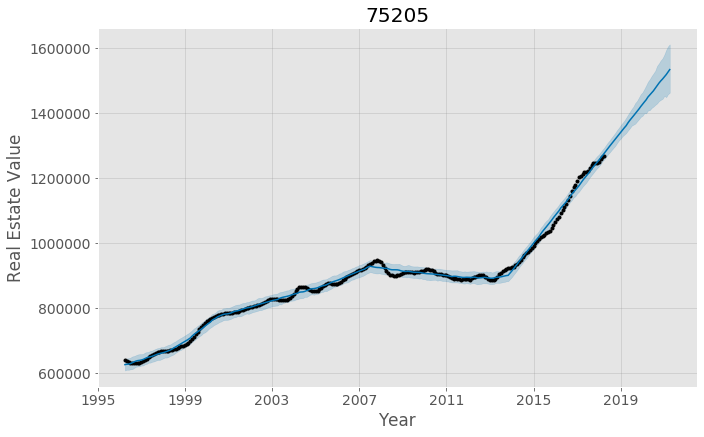

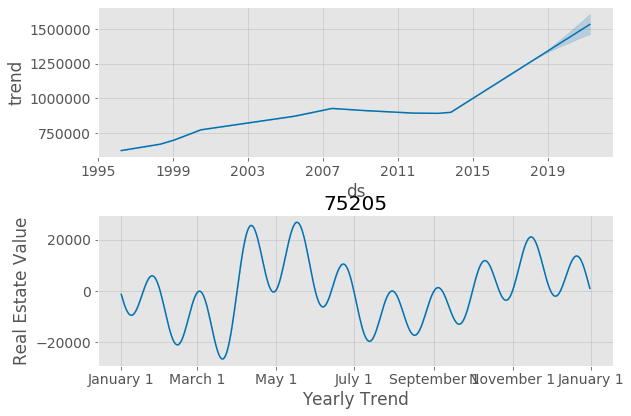

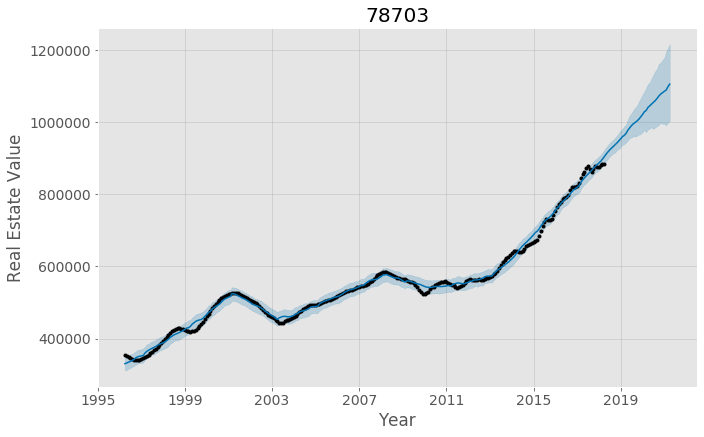

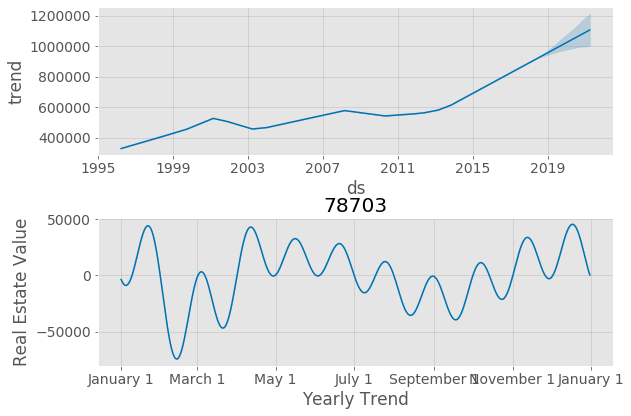

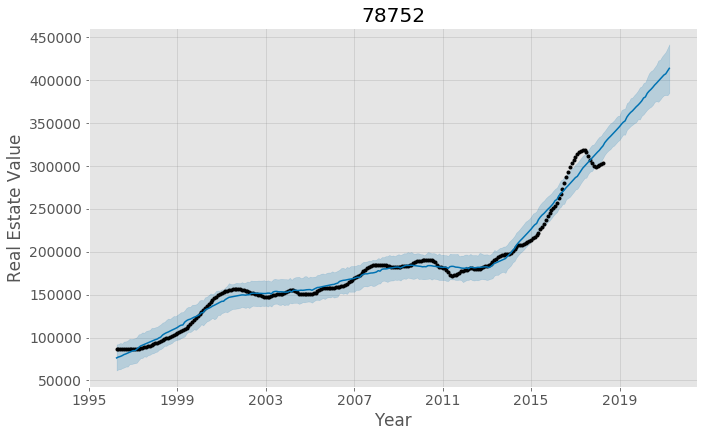

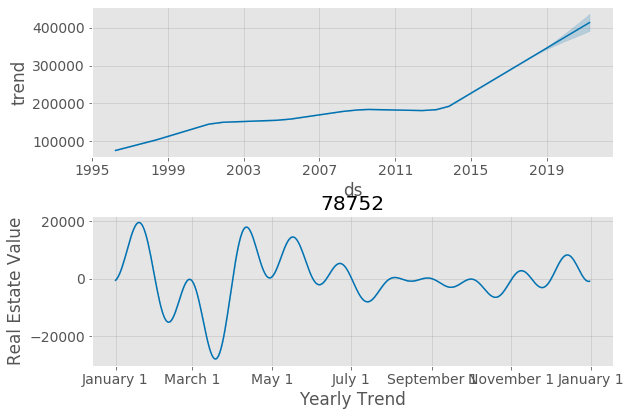

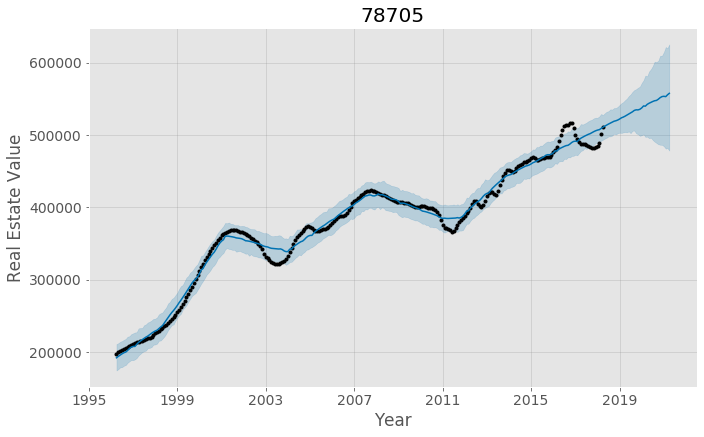

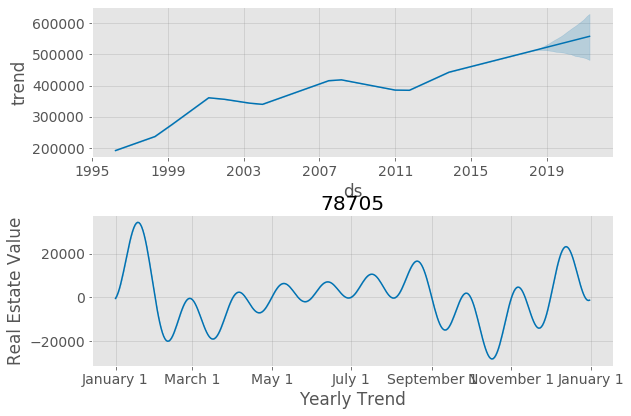

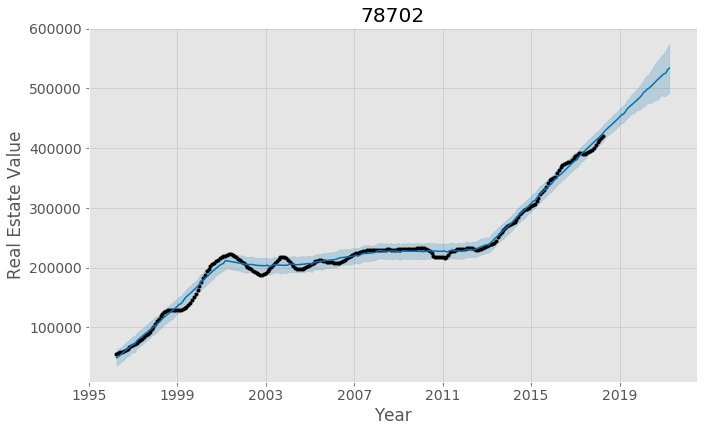

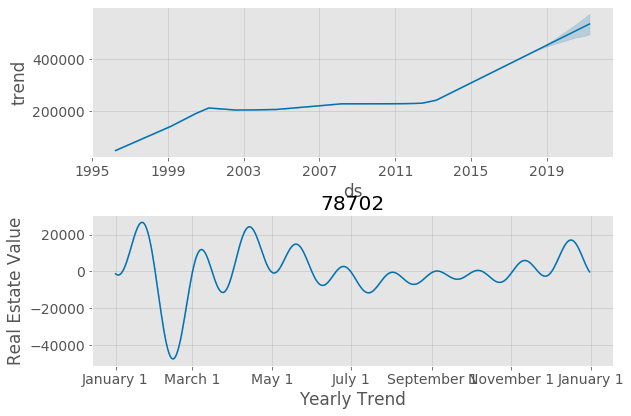

In [205]:
vals, forecasted_data = prophet_prediction(ts, zipcodes)

In [206]:
vals




[(75205, 1268600, 257293.02, 0.2),
 (78703, 885300, 201293.92, 0.22),
 (78752, 303100, 90397.71, 0.28),
 (78705, 511600, 46800.95, 0.09),
 (78702, 419800, 109144.84, 0.26)]

Facebook Prophet Model results are slightly different than SARIMAX model result. Estmations are a little bit higher. But the trends are the same. Facebook prophit model gives us a better confident interval which is narrover possible price range. It is shaded area in the plot. 
I would like to test these models performence by running the models with train test split 




# Step 7: Testing the Performence of ARIMA Model

I will visually check the performence of ARIMA forecasting for selected Zipcode. I will use train/test split method to see how accurate the forecasted data will be. I will plot both data on the same axis. 



In [207]:
df_1=ts.iloc[:,:1]
zipcode=[78702]
zipcode

[78702]

In [208]:
smallts=ts[78702].iloc[:80]
#smallts.tail(28)


Zipcode : 75205
Test MSE: 2370.664
Standart Deviation: 128895.16481099353
                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  264
Model:             SARIMAX(3, 1, 1)x(3, 1, 1, 12)   Log Likelihood               -1857.529
Date:                            Fri, 25 Oct 2019   AIC                           3733.058
Time:                                    10:44:27   BIC                           3763.267
Sample:                                         0   HQIC                          3745.268
                                            - 264                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0307      0.127      8.

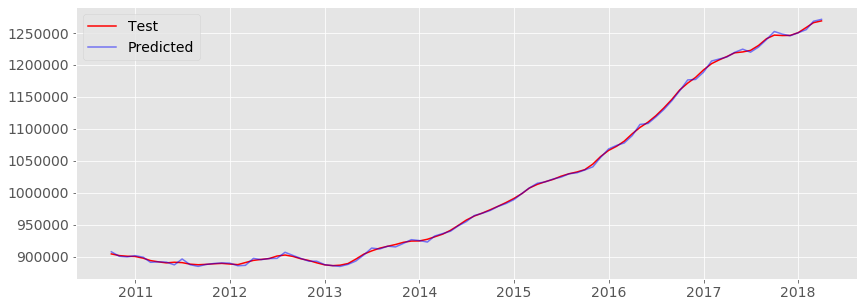

Zipcode : 78703
Test MSE: 3251.378
Standart Deviation: 116652.11854596007
                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  264
Model:             SARIMAX(3, 1, 1)x(3, 1, 1, 12)   Log Likelihood               -1936.286
Date:                            Fri, 25 Oct 2019   AIC                           3890.572
Time:                                    11:03:23   BIC                           3920.781
Sample:                                         0   HQIC                          3902.782
                                            - 264                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0175      0.144      7.

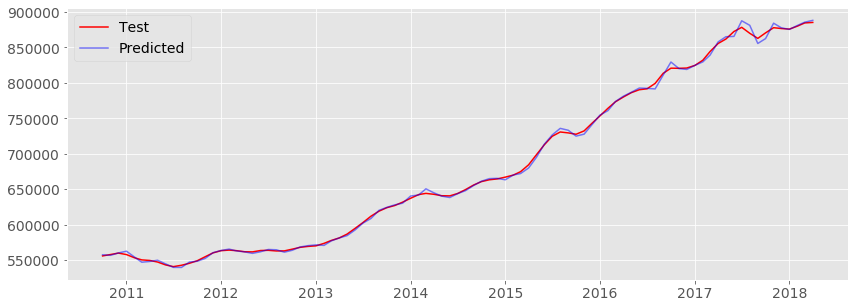

Zipcode : 78752
Test MSE: 778.744
Standart Deviation: 50104.47541595587
                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  264
Model:             SARIMAX(3, 1, 1)x(3, 1, 1, 12)   Log Likelihood               -1626.683
Date:                            Fri, 25 Oct 2019   AIC                           3271.366
Time:                                    11:23:12   BIC                           3301.575
Sample:                                         0   HQIC                          3283.576
                                            - 264                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1516      0.111     10.38

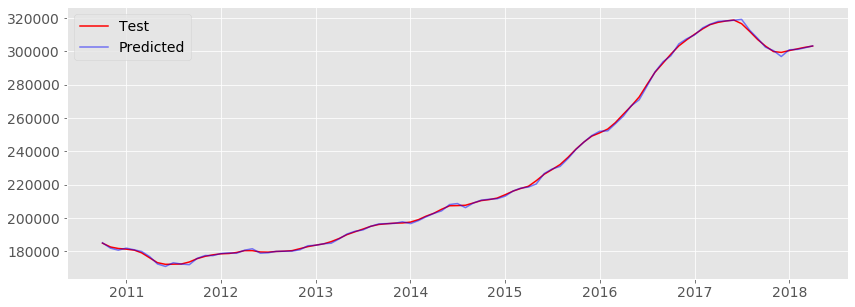

Zipcode : 78705
Test MSE: 2113.006
Standart Deviation: 44787.79589387354
                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  264
Model:             SARIMAX(3, 1, 1)x(3, 1, 1, 12)   Log Likelihood               -1828.146
Date:                            Fri, 25 Oct 2019   AIC                           3674.293
Time:                                    11:48:57   BIC                           3704.502
Sample:                                         0   HQIC                          3686.503
                                            - 264                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1298      0.136      8.3

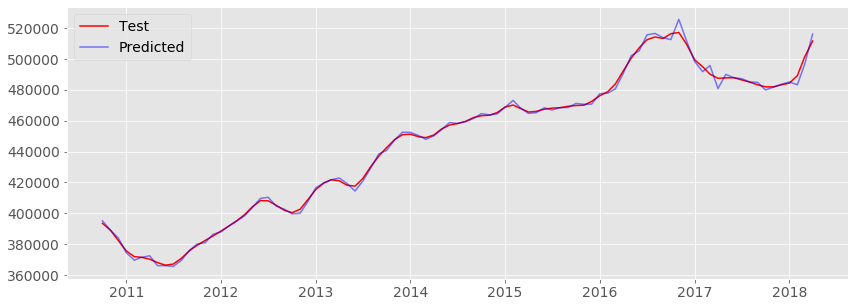

Zipcode : 78702
Test MSE: 890.554
Standart Deviation: 66716.43826589583
                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  264
Model:             SARIMAX(3, 1, 1)x(3, 1, 1, 12)   Log Likelihood               -1686.599
Date:                            Fri, 25 Oct 2019   AIC                           3391.197
Time:                                    12:10:16   BIC                           3421.406
Sample:                                         0   HQIC                          3403.407
                                            - 264                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5066      0.075     20.07

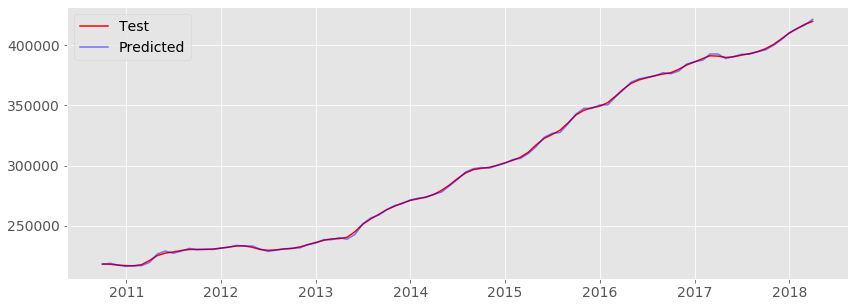

In [270]:
from sklearn.metrics import mean_squared_error
pdq_new=(3,1,1)
pdqs_new=(3,1,1,12)


for i in zipcodes:


    X = ts[i]
    size = int(len(X) * 0.66)
    train, test = X[0:size], X[size:len(X)]
    history = [x for x in train]
    predictions = list()


    for t in range(len(test)):
        model = sm.tsa.statespace.SARIMAX(history,
                                        order=pdq_new,
                                        seasonal_order=pdqs_new,
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
        #print('predicted=%f, expected=%f' % (yhat, obs))


    error = np.sqrt(mean_squared_error(test, predictions))
    print("Zipcode :", i )
    print('Test RMSE: %.3f' % error)
    print('Standart Deviation:' , np.std(test))
    print(model_fit.summary())
    
    plt.figure(figsize=(14,5))
    #plt.plot(train, label='Train')
    plt.plot(test, color='red', label="Test")
    plt.plot(test.index, predictions, color='blue', label="Predicted", alpha=0.5)
    plt.legend()
    plt.show()  

We can say that the forecasted data is pretty accurate when we compare with the observed data in the test dataset. That allows us to be confident aboout the forecasted price after 2018 as well.

In [ ]:
#import folium



# Step 8: Conclusion

In [211]:
report_3_yrs

,Zipcode,City,State,Metro,Investment,Price_in_3_yrs,Growth_Rate,Predict_min,Predict_max,Risk_Rate
6,75205,University Park,TX,Dallas-Fort Worth,1268600,1475245.0,0.16,1269124.0,1681366.0,0.139720
3,78703,Austin,TX,Austin,885300,1017537.0,0.15,769902.0,1265171.0,0.243366
7,78752,Austin,TX,Austin,303100,344202.0,0.14,277373.0,411031.0,0.194156
9,78705,Austin,TX,Austin,511600,579046.0,0.13,418769.0,739322.0,0.276793
0,78702,Austin,TX,Austin,419800,465739.0,0.11,378902.0,552577.0,0.186452


In [212]:
report_5_yrs

,Zipcode,City,State,Metro,Investment,Price_in_5_yrs,Growth_Rate,Predict_min,Predict_max,Risk_Rate
6,75205,University Park,TX,Dallas-Fort Worth,1268600,1614455.0,0.27,1231511.0,1997400.0,0.237198
3,78703,Austin,TX,Austin,885300,1107801.0,0.25,648691.0,1566911.0,0.414434
7,78752,Austin,TX,Austin,303100,365730.0,0.21,270887.0,460573.0,0.259325
9,78705,Austin,TX,Austin,511600,620724.0,0.21,316874.0,924575.0,0.489511
0,78702,Austin,TX,Austin,419800,500701.0,0.19,376497.0,624906.0,0.248062


 
 
  - **The best zipcodes to invest in Texas are 75205, 78703, 78752, 78705, 78702**
  
  - **The best range for investment is 100K-500K in terms of the rate of price increase. These are mostly the affordable residential houses**
  
  - **78703, 78752, 78705, 78702 are in Austin, the capitol city of Texas. It is not surprising because Austin has been one of the fastest growing city in US. Austin Metro Area has the fastest growing real estate market in Texas. All major high tech companies are moving there including Google and Apple. DELL and IBM has been born in Austin as well. It is already been called Silicon Hills for quite a while. Beacuse of the numerous high tech companies openning branches in Austin last 10 years, the increasing trend is expected to be long term. So, the longer investment horizon could be rewarding, despite the increased risk on the model's forecast.**
  
  - **75205 is in University Park. It is a decidedly white-collar city, with fully 97.43% of the workforce employed in white-collar jobs, well above the national average. University Park home prices are not only among the most expensive in Texas, but University Park real estate also consistently ranks among the most expensive in America.**
  
  


# Future Work


- These analysis can be done for all states. It could be done easily done with this code just by passign the desired state in to filtering function.
- The risk analysis could be done more detailed.
- Growth rate, increase and risk factors can be cross referenced before filtering

